In [5]:
import numpy as np
import matplotlib.pyplot as plt
import random
from collections import defaultdict
import time


In [ ]:
class GridWorld:
    def __init__(self, size=100):
        self.size = size
        self.grid = np.zeros((size, size))
        self.start = (0, 0)
        self.goal = (size - 1, size - 1)
        self.obstacles = self.generate_obstacles()
        self.grid[self.start] = 1  
        self.grid[self.goal] = 2
        for obs in self.obstacles:
            self.grid[obs] = -1

    def generate_obstacles(self):
        p1 = (random.randint(0, self.size - 1), random.randint(0, self.size - 1))
        p2 = (random.randint(0, self.size - 1), random.randint(0, self.size - 1))
        obstacles = []
        dx = abs(p2[0] - p1[0])
        dy = abs(p2[1] - p1[1])
        sx = 1 if p1[0] < p2[0] else -1
        sy = 1 if p1[1] < p2[1] else -1
        err = (dx if dx > dy else -dy) / 2

        x, y = p1
        while True:
            if 0 <= x < self.size and 0 <= y < self.size and (x, y) != self.start and (x, y) != self.goal:
                obstacles.append((x, y))
            if x == p2[0] and y == p2[1]:
                break
            e2 = err
            if e2 > -dx:
                err -= dy
                x += sx
            if e2 < dy:
                err += dx
                y += sy
        return obstacles

    def step(self, state, action):
        x, y = state
        if action == 0:  # Up
            next_state = (max(0, x - 1), y)
        elif action == 1:  # Down
            next_state = (min(self.size - 1, x + 1), y)
        elif action == 2:  # Left
            next_state = (x, max(0, y - 1))
        elif action == 3:  # Right
            next_state = (x, min(self.size - 1, y + 1))

        if self.grid[next_state] == -1:
            next_state = state

        reward = -1
        if next_state == self.goal:
            reward = 100

        done = next_state == self.goal
        return next_state, reward, done

    def render(self, agent_pos=None):
        plt.imshow(self.grid, cmap='viridis', interpolation='nearest')
        if agent_pos:
            plt.scatter(agent_pos[1], agent_pos[0], c='red', marker='o')
        plt.show()


In [ ]:
def value_iteration(env, gamma=0.99, theta=1e-4):
    V = np.zeros((env.size, env.size))
    policy = np.zeros((env.size, env.size))

    while True:
        delta = 0
        for x in range(env.size):
            for y in range(env.size):
                state = (x, y)
                if state == env.goal:
                    continue  # Terminal state

                v = V[state]
                max_v = -np.inf
                best_action = None

                for action in range(4):
                    next_state, reward, done = env.step(state, action)
                    new_v = reward + (gamma * V[next_state] if not done else 0)
                    if new_v > max_v:
                        max_v = new_v
                        best_action = action

                V[state] = max_v
                policy[state] = best_action
                delta = max(delta, abs(v - V[state]))

        if delta < theta:
            break
    return V, policy


# Q-learning
def q_learning(env, alpha=0.1, gamma=0.99, epsilon=0.1, episodes=10, early_stop_patience=100):
    Q = defaultdict(lambda: np.zeros(4))
    rewards = []
    best_avg_reward = -np.inf
    no_improvement_count = 0

    for episode in range(episodes):
        state = env.start
        episode_reward = 0
        
        for _ in range(10000):
            if random.uniform(0, 1) < epsilon:
                action = random.choice(range(4))
            else:
                action = np.argmax(Q[state])

            next_state, reward, done = env.step(state, action)
            Q[state][action] += alpha * (reward + gamma * np.max(Q[next_state]) - Q[state][action])
            episode_reward += reward
            state = next_state
            if done:
                break

        rewards.append(episode_reward)

        # Early stopping
        avg_reward = np.mean(rewards[-100:])
        if avg_reward > best_avg_reward:
            best_avg_reward = avg_reward
            no_improvement_count = 0
        else:
            no_improvement_count += 1
            if no_improvement_count >= early_stop_patience:
                print("Early stopping triggered.")
                break
    return Q, rewards

In [ ]:

def policy_iteration(env, gamma=0.99, theta=1e-4):
    V = np.zeros((env.size, env.size))
    policy = np.random.randint(0, 4, size=(env.size, env.size))

    while True:
        # Policy Evaluation
        while True:
            delta = 0
            for x in range(env.size):
                for y in range(env.size):
                    state = (x, y)
                    if state == env.goal:
                        continue

                    v = V[state]
                    action = policy[state]
                    next_state, reward, done = env.step(state, action)
                    V[state] = reward + (gamma * V[next_state] if not done else 0)
                    delta = max(delta, abs(v - V[state]))
            if delta < theta:
                break

        # Policy Improvement
        policy_stable = True
        for x in range(env.size):
            for y in range(env.size):
                state = (x, y)
                if state == env.goal:
                    continue

                old_action = policy[state]
                max_v = -np.inf
                best_action = None

                for action in range(4):
                    next_state, reward, done = env.step(state, action)
                    new_v = reward + (gamma * V[next_state] if not done else 0)
                    if new_v > max_v:
                        max_v = new_v
                        best_action = action

                policy[state] = best_action
                if old_action != best_action:
                    policy_stable = False

        if policy_stable:
            break

    return V, policy

Value Iteration Time: 8.0010 seconds
Policy Iteration Time: 25.1017 seconds


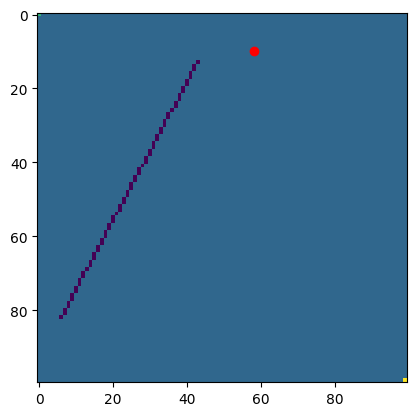

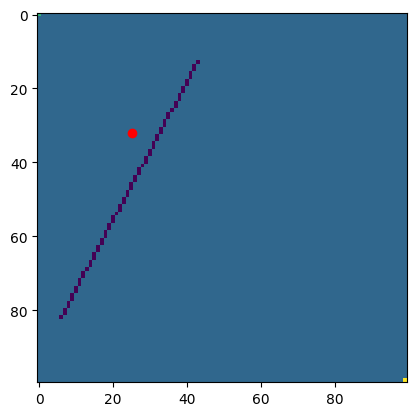

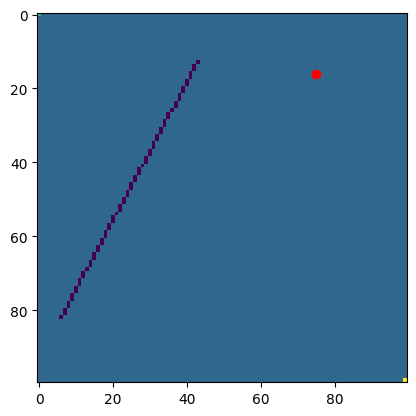

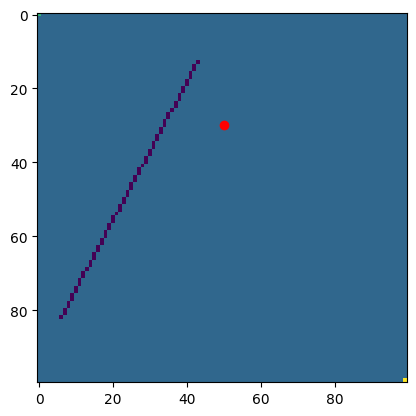

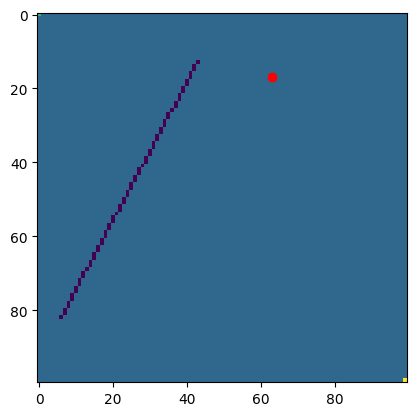

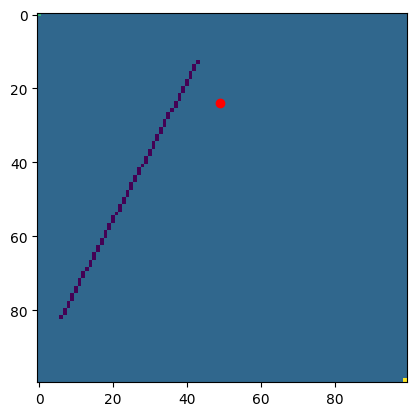

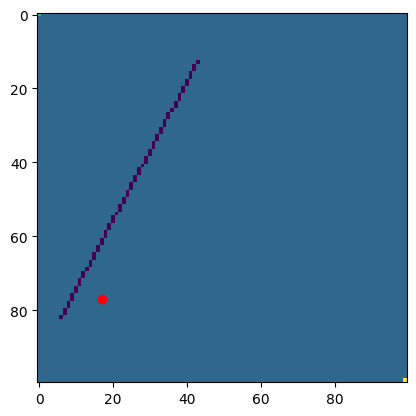

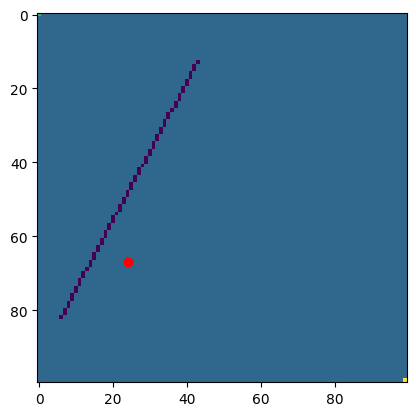

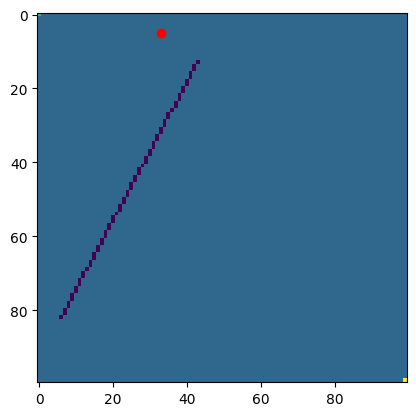

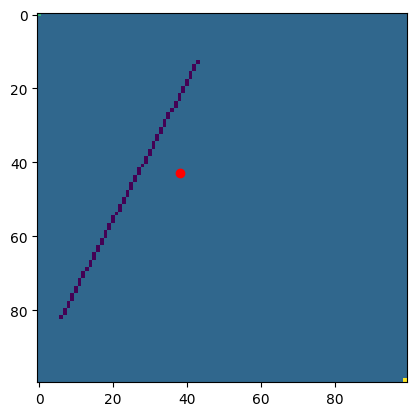

Q-learning Time: 1.5323 seconds


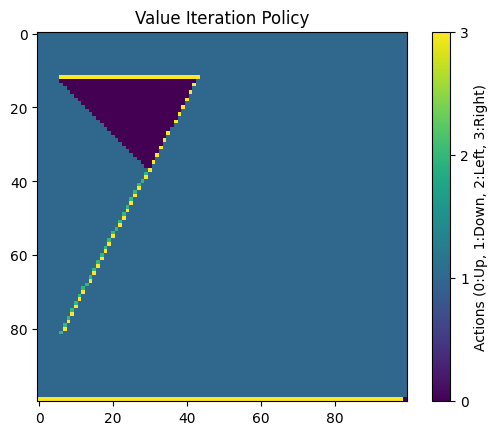

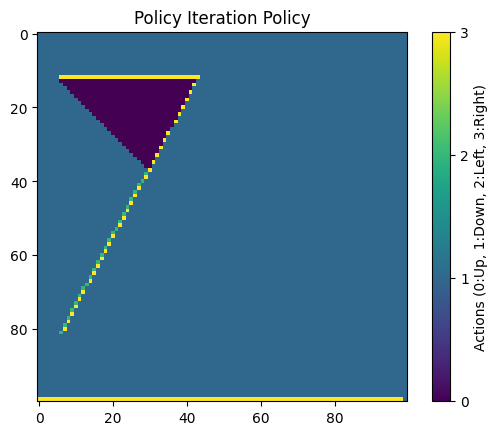

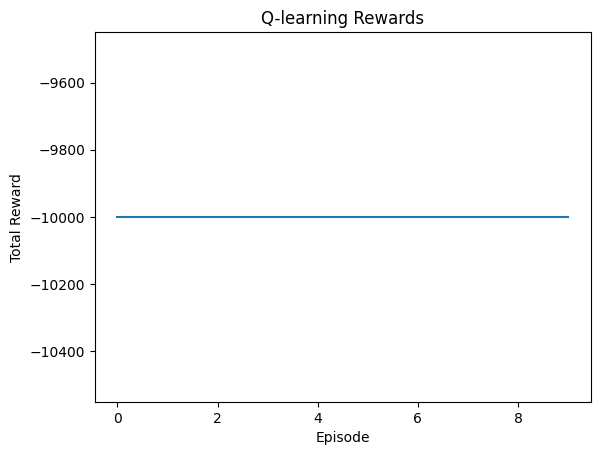

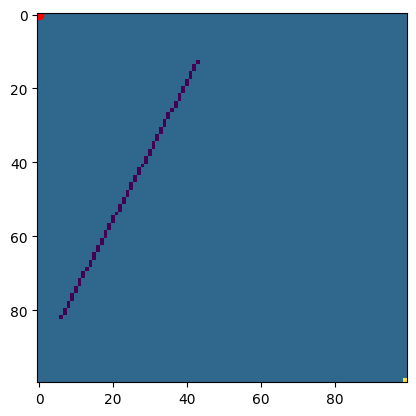

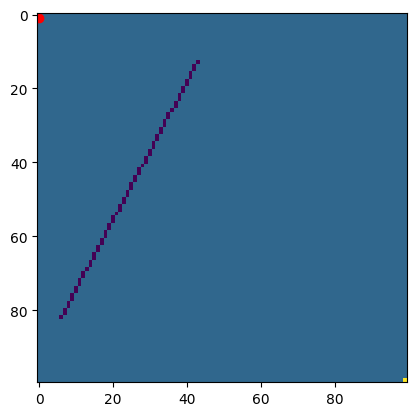

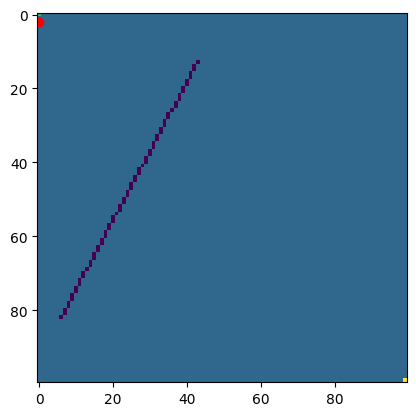

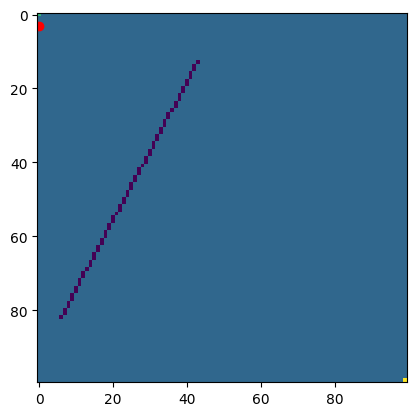

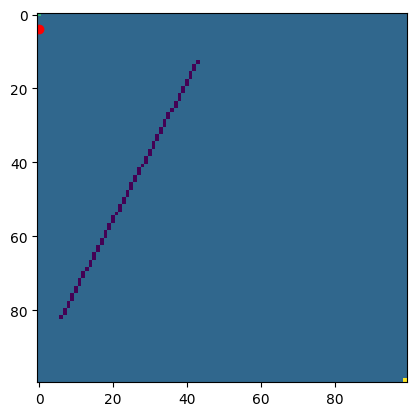

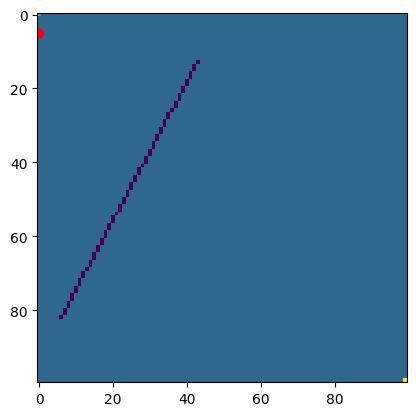

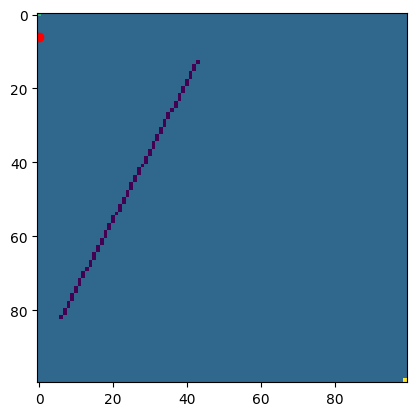

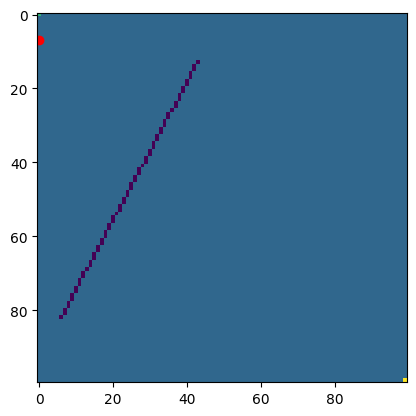

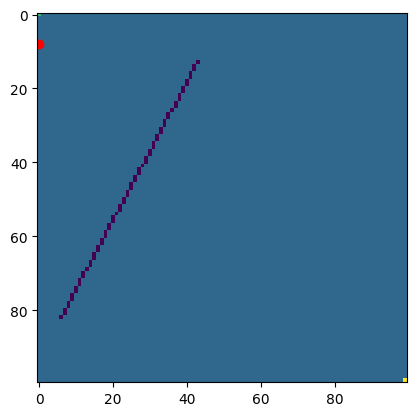

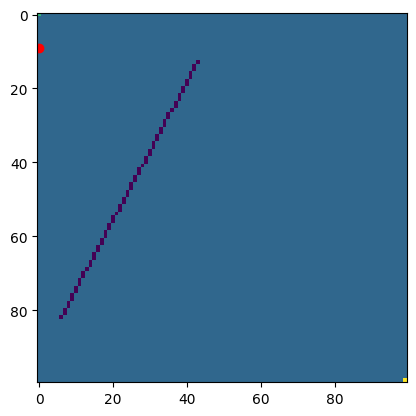

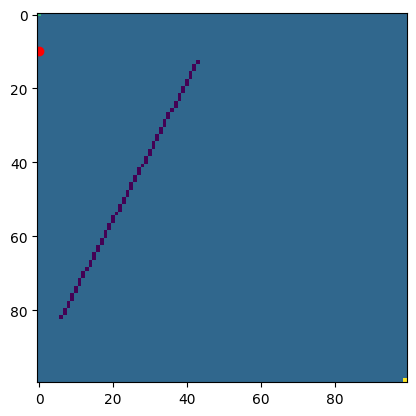

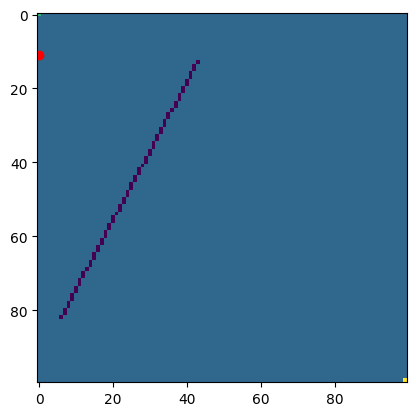

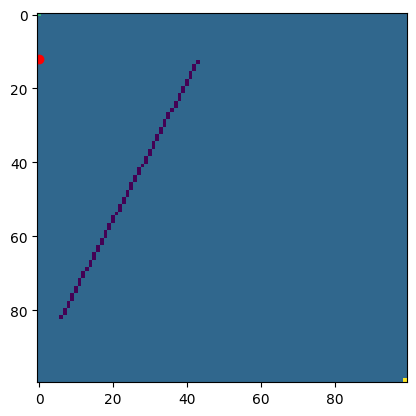

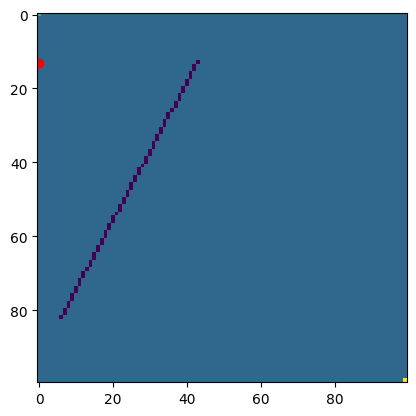

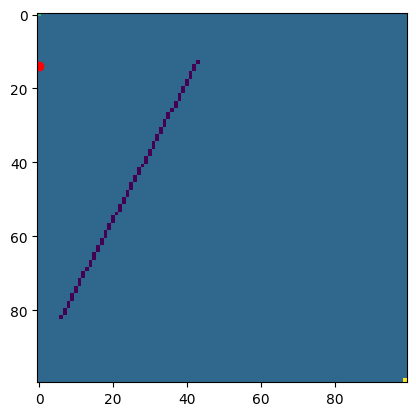

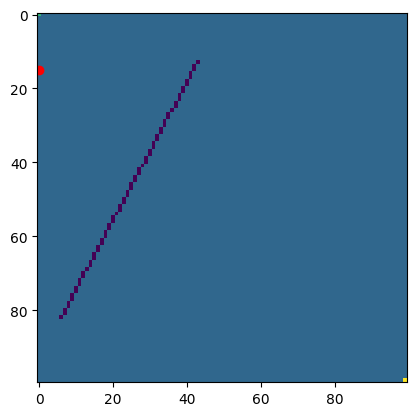

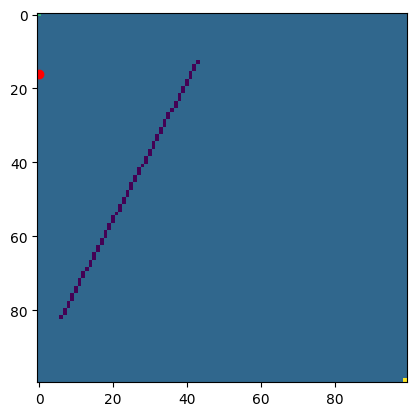

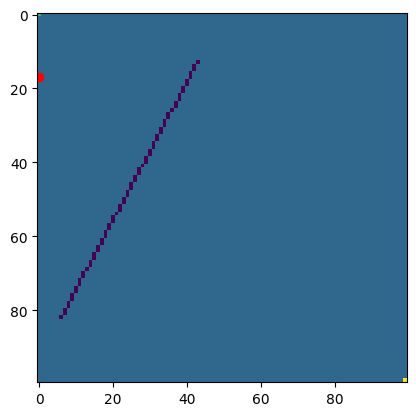

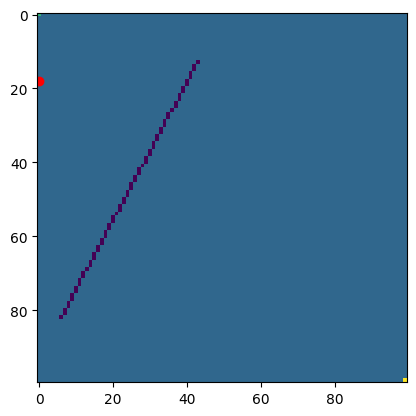

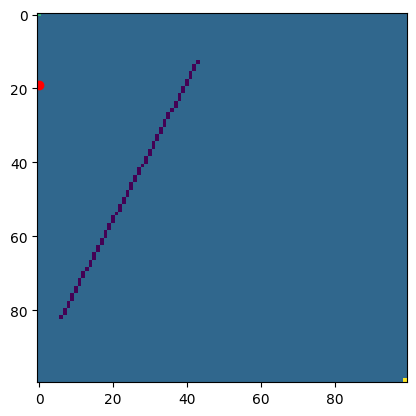

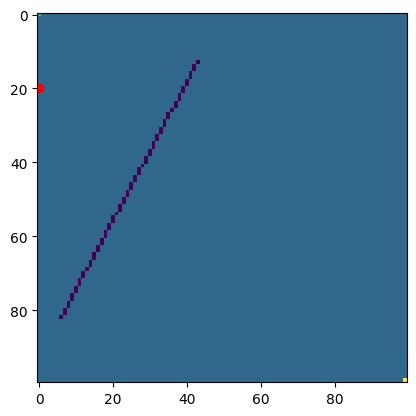

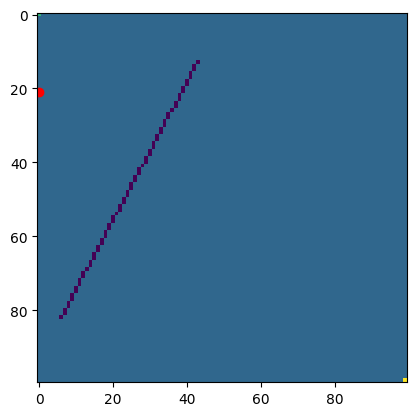

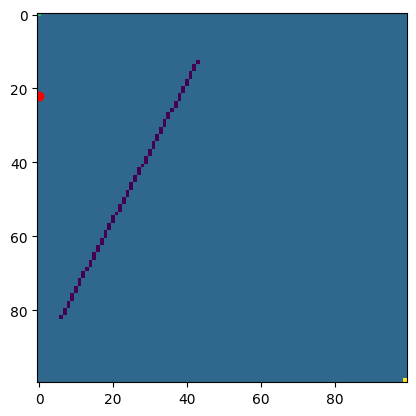

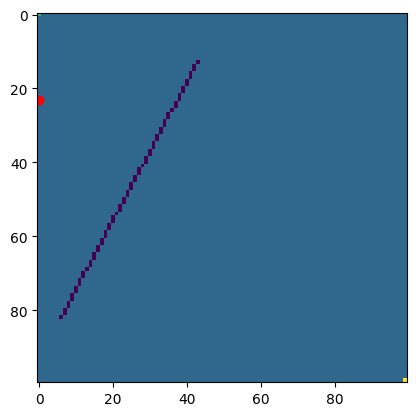

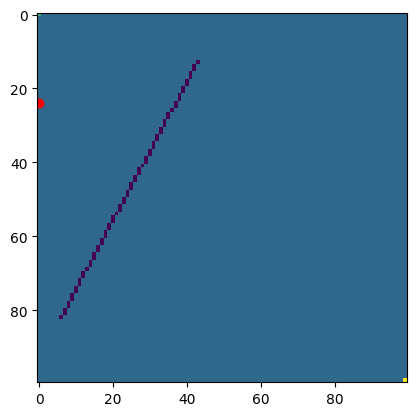

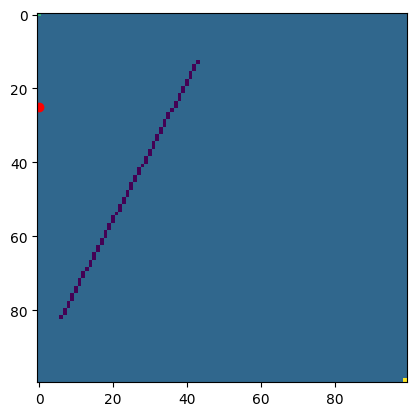

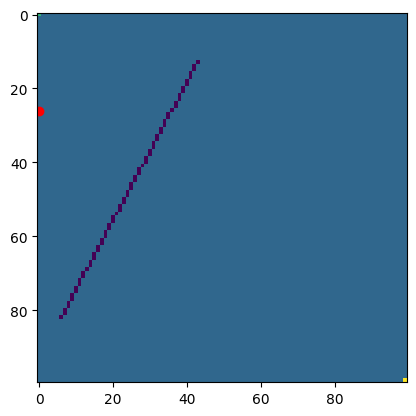

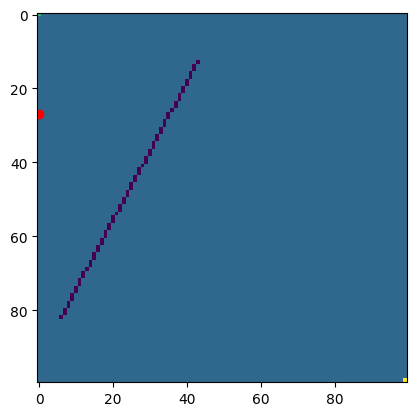

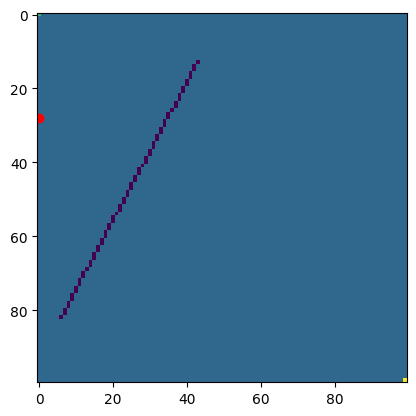

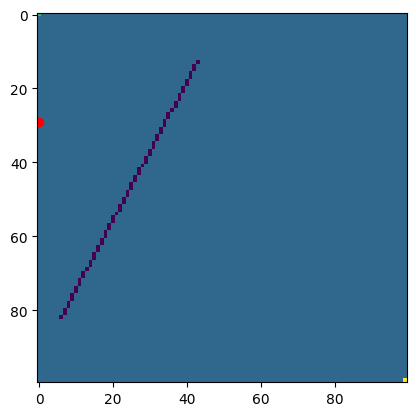

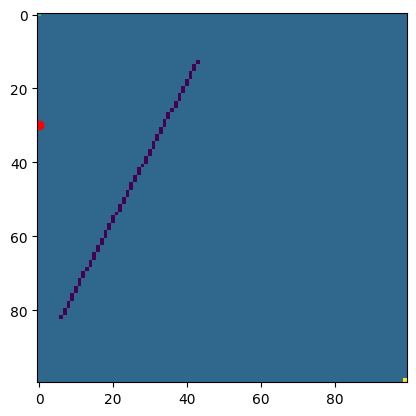

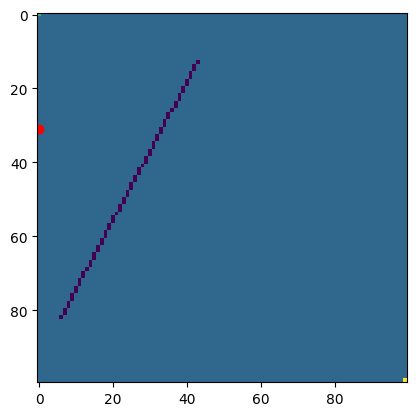

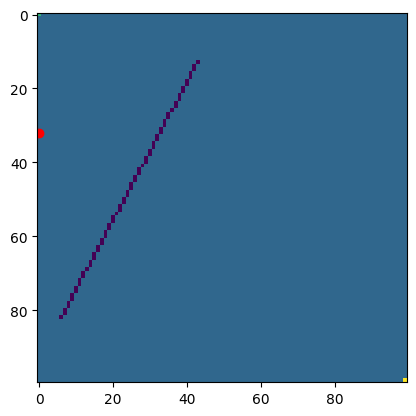

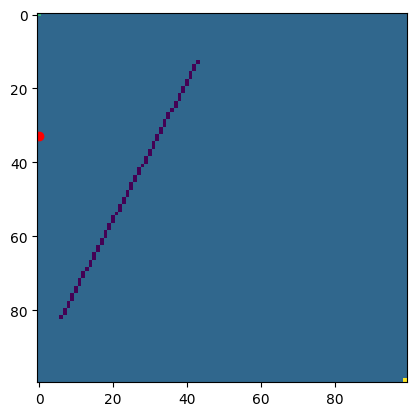

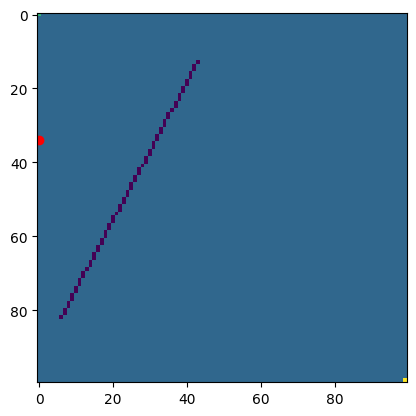

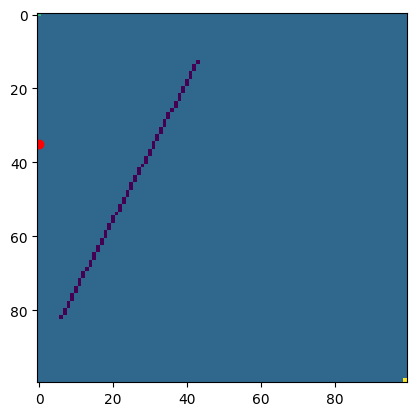

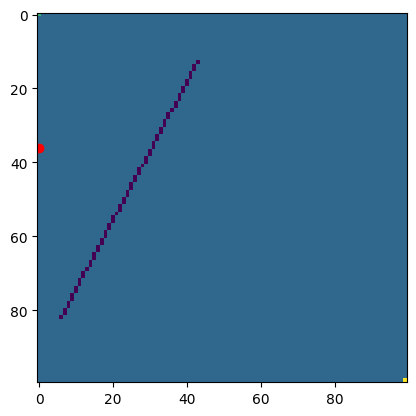

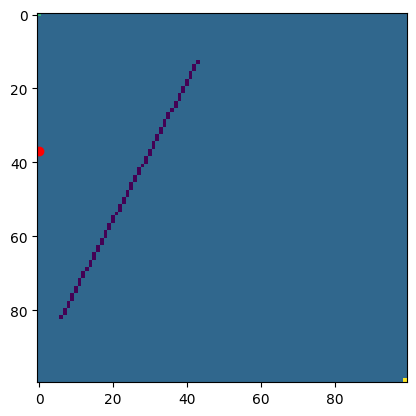

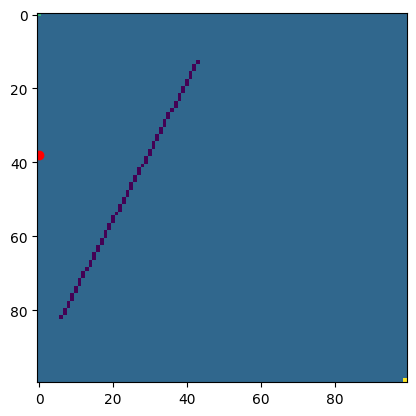

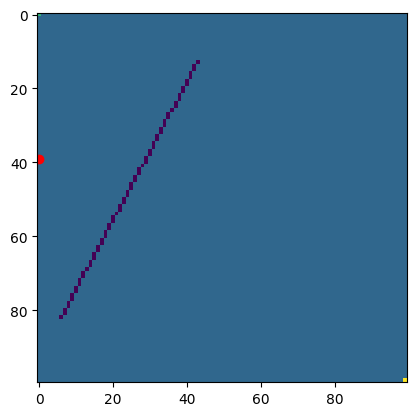

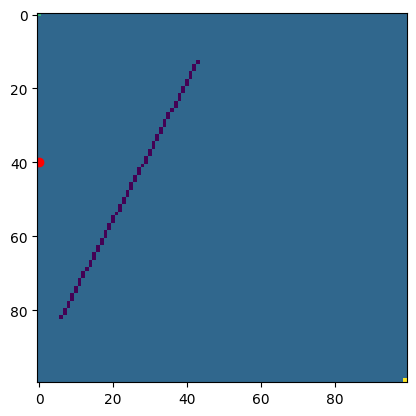

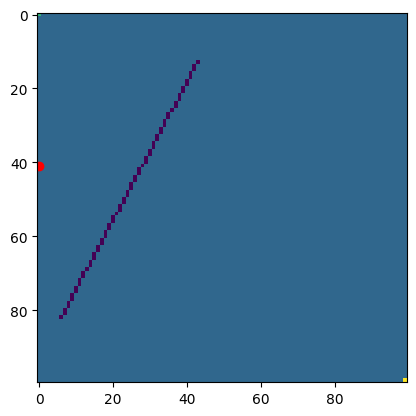

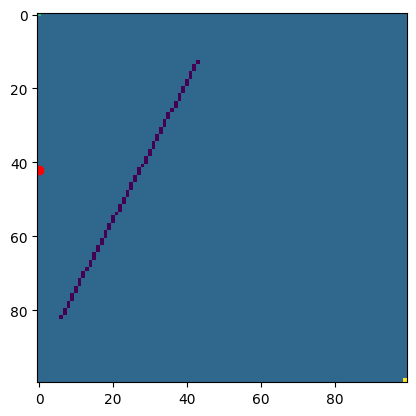

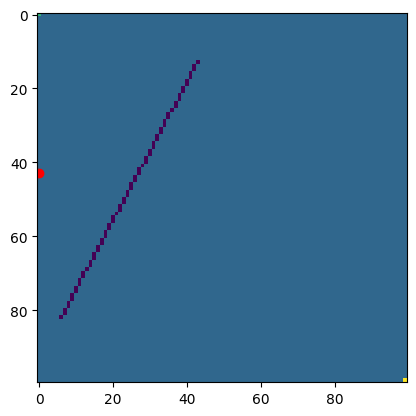

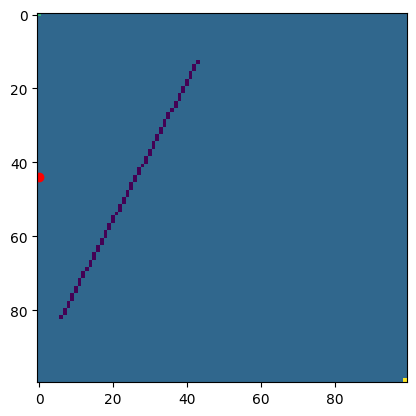

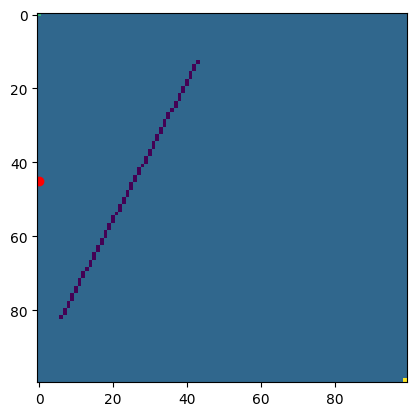

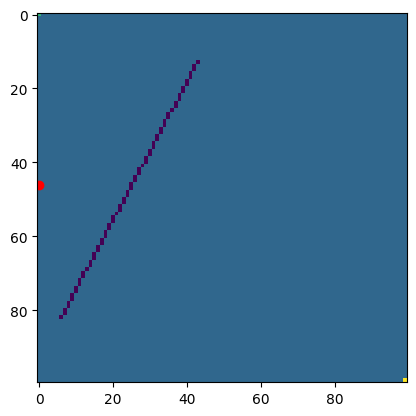

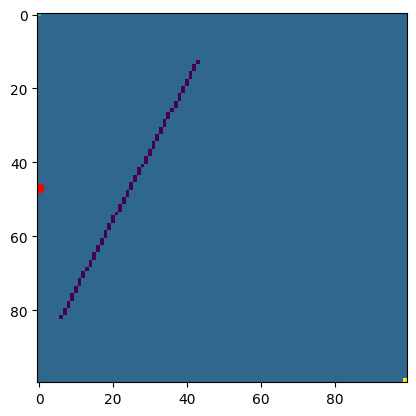

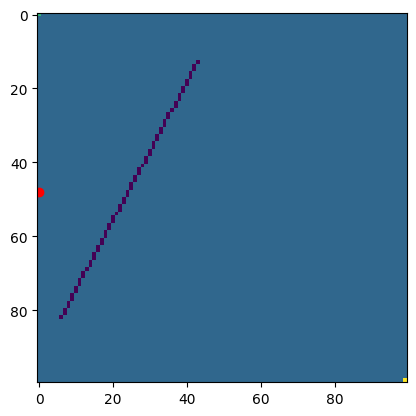

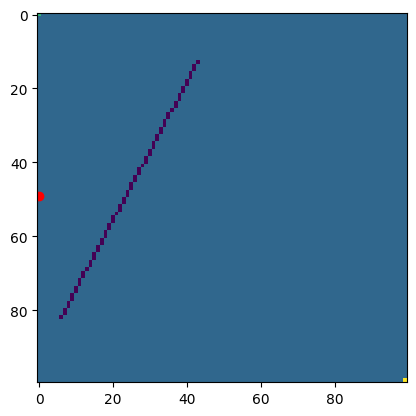

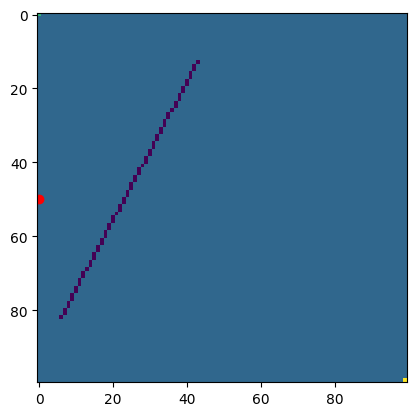

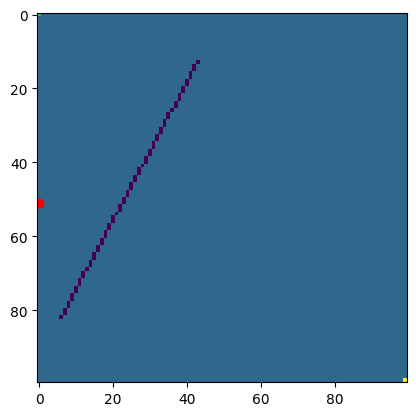

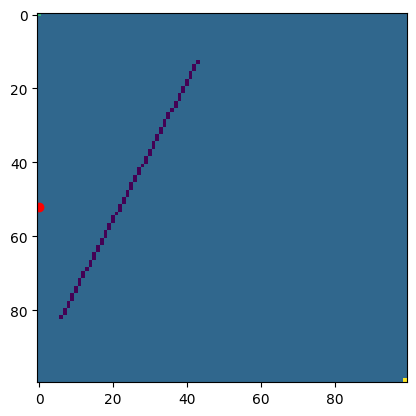

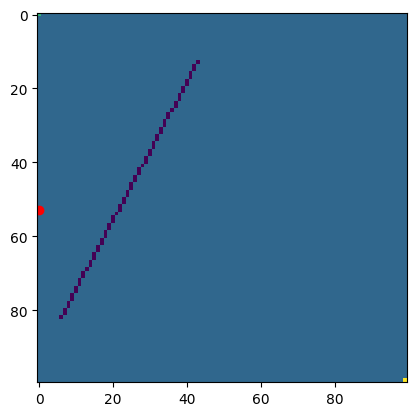

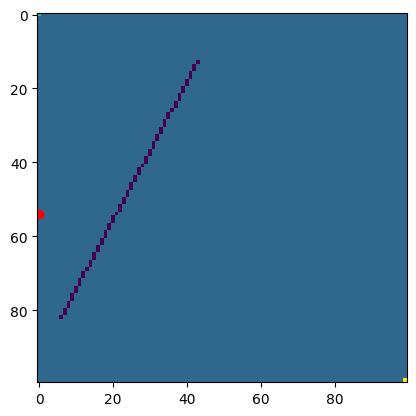

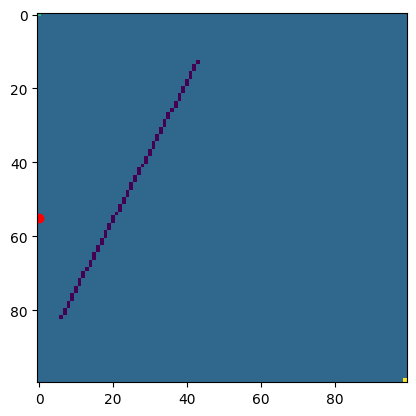

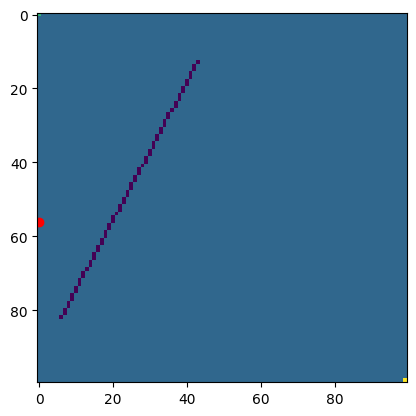

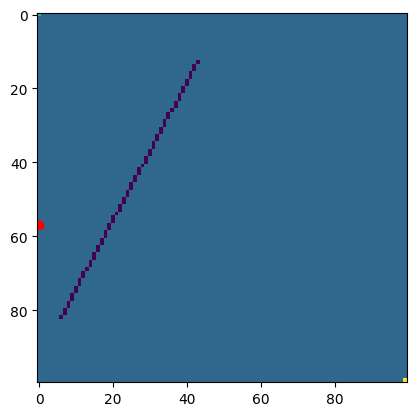

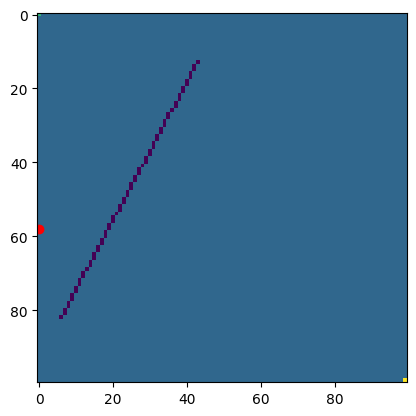

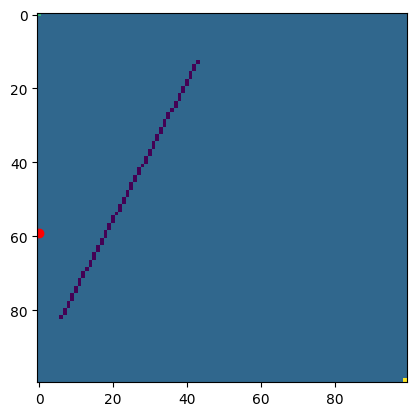

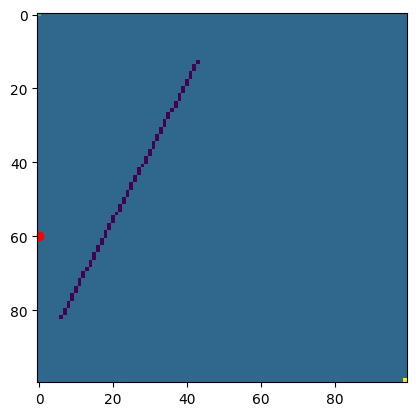

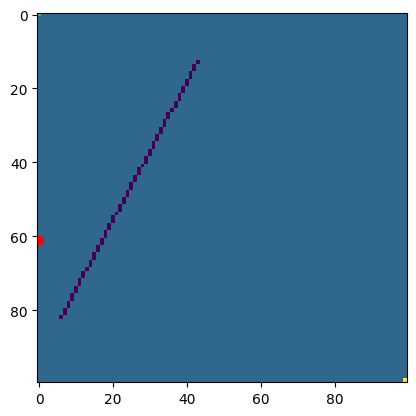

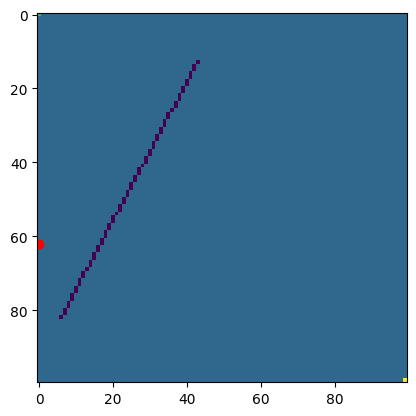

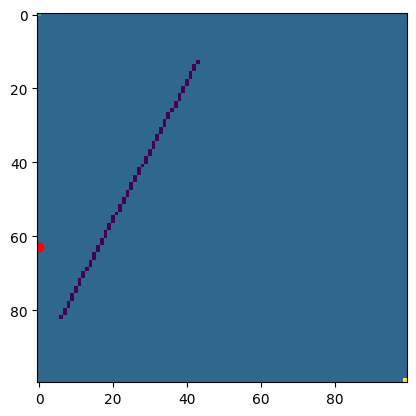

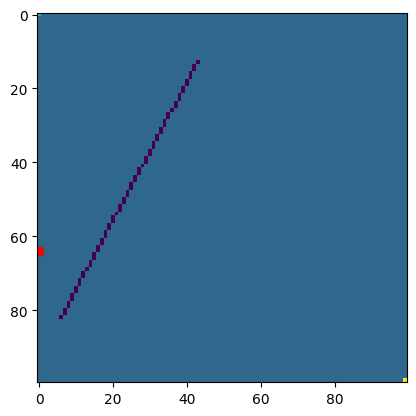

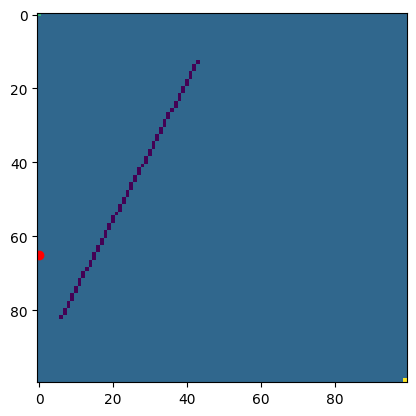

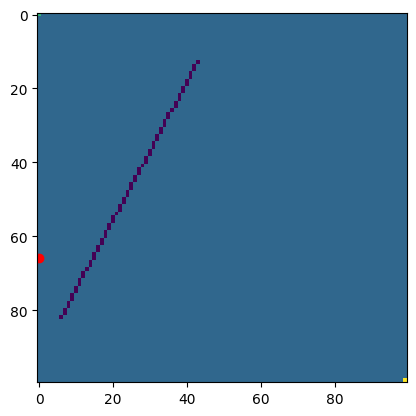

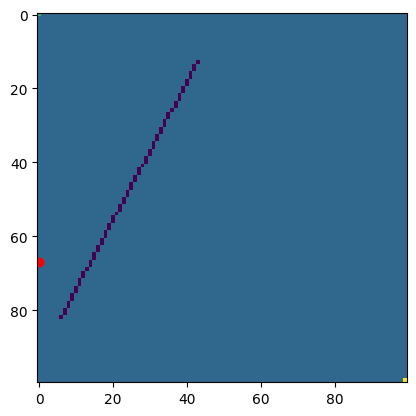

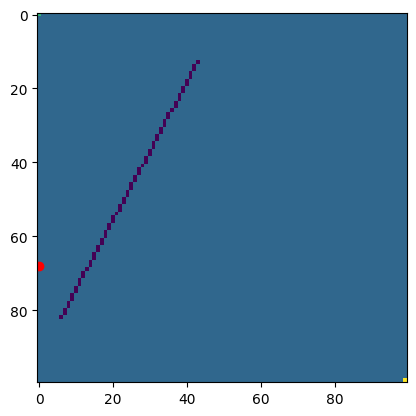

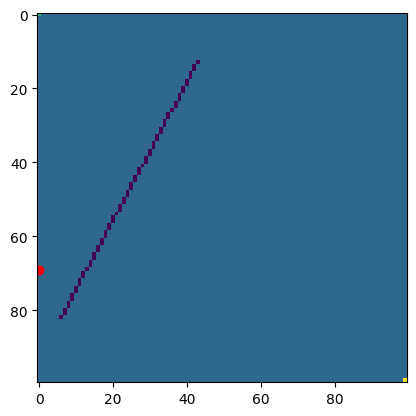

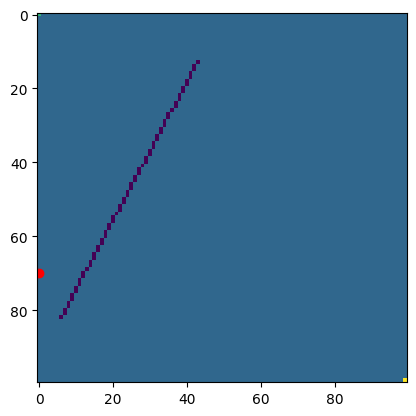

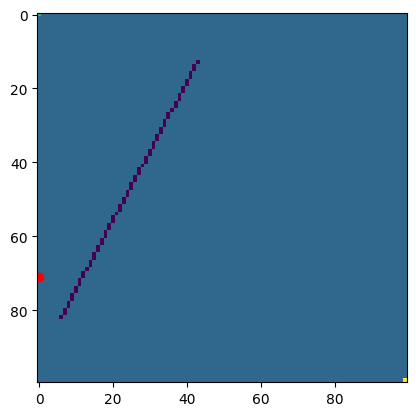

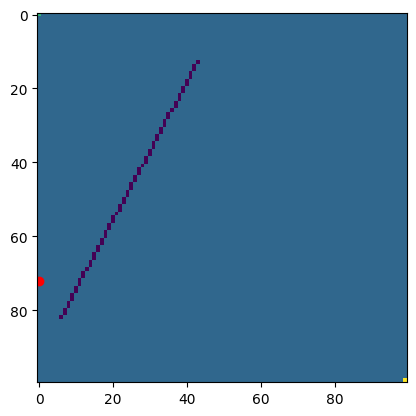

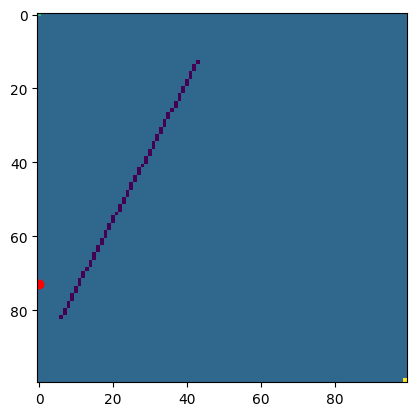

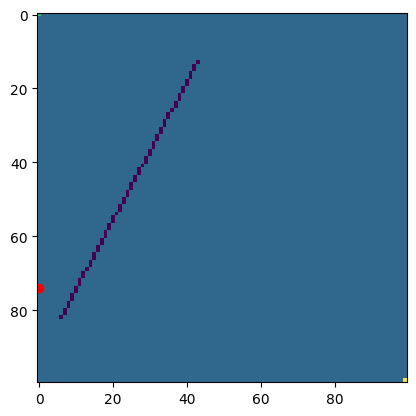

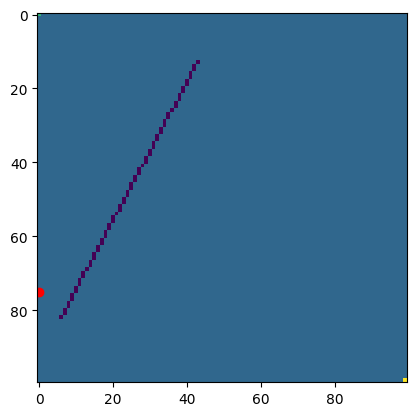

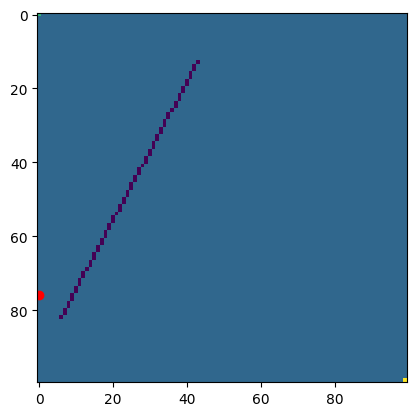

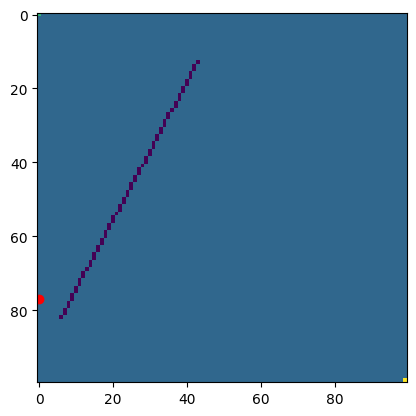

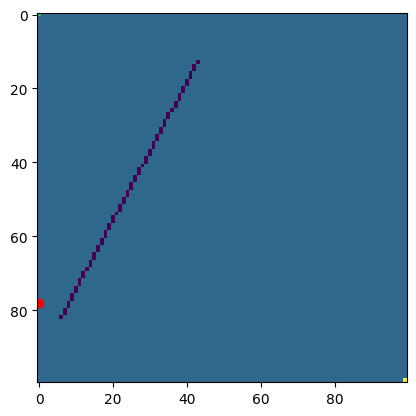

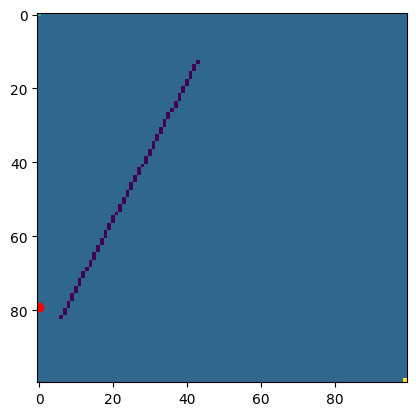

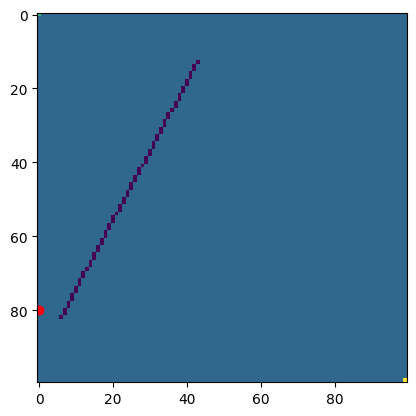

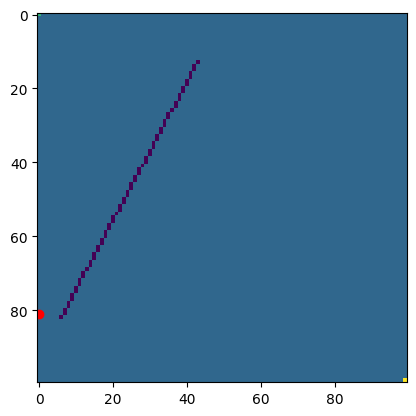

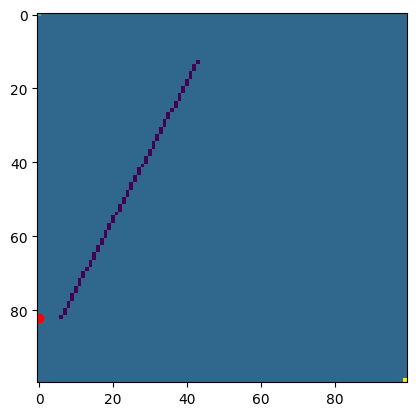

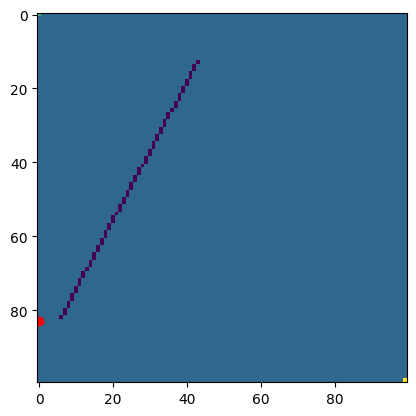

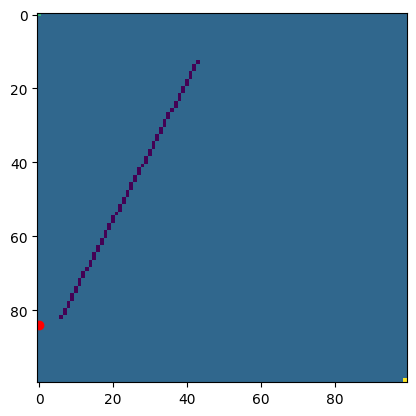

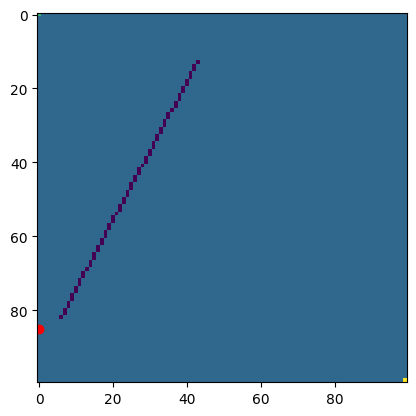

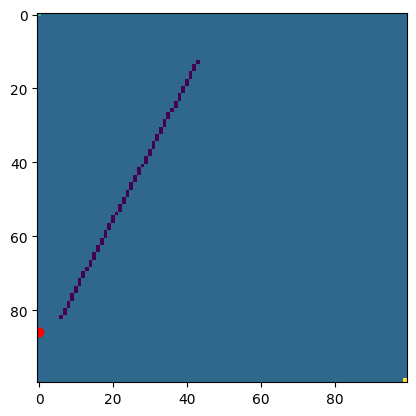

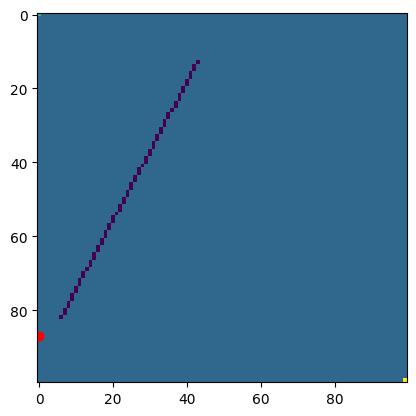

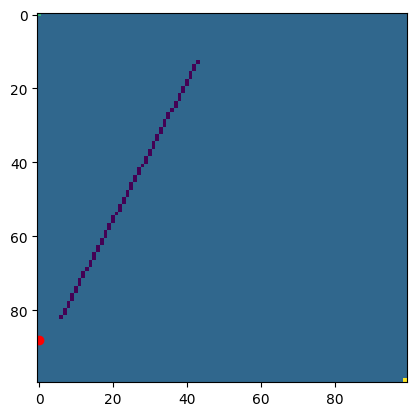

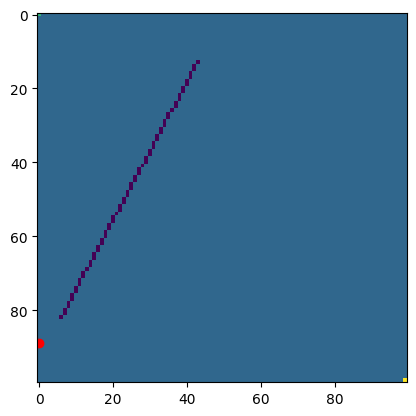

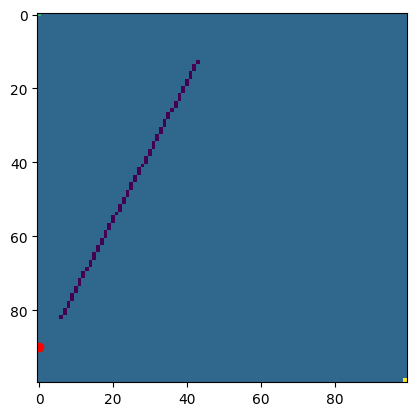

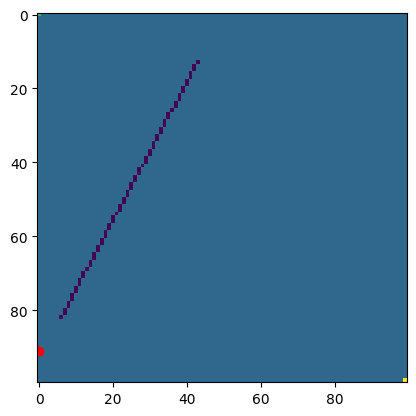

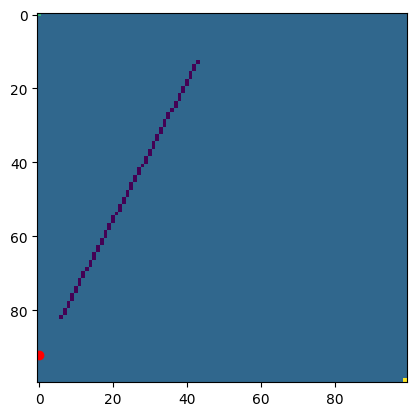

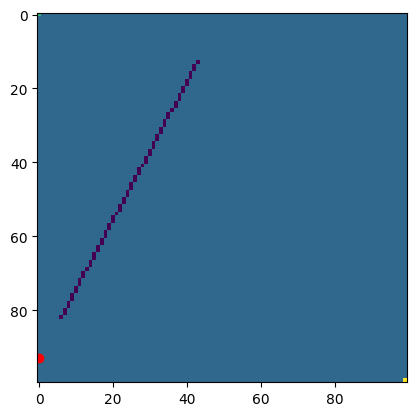

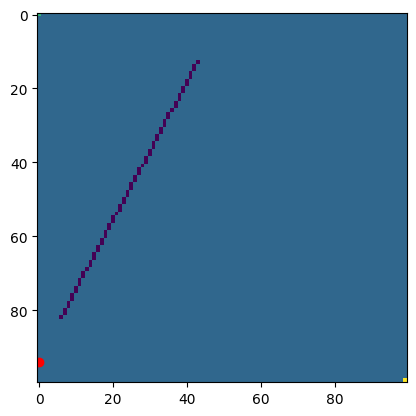

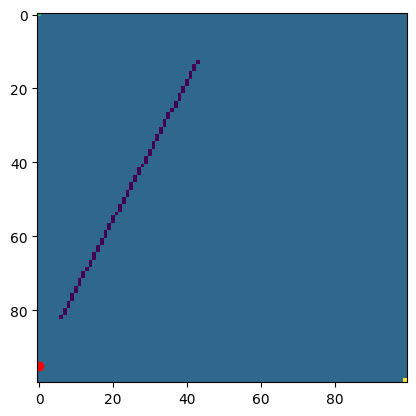

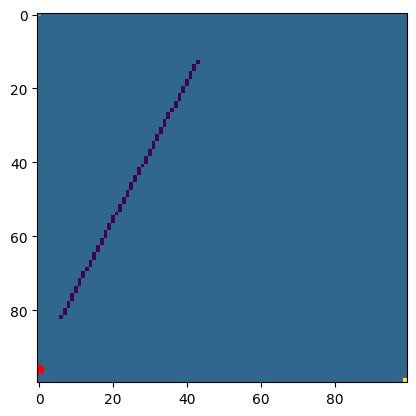

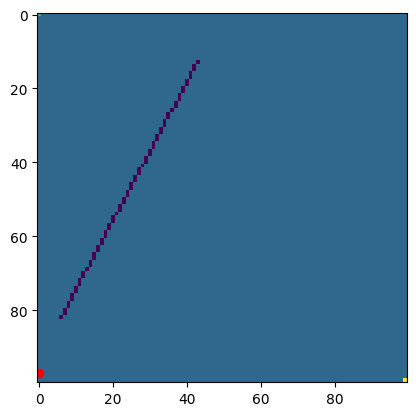

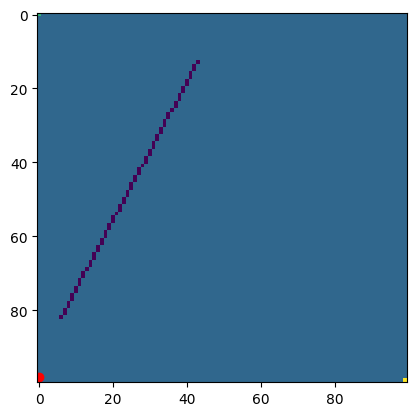

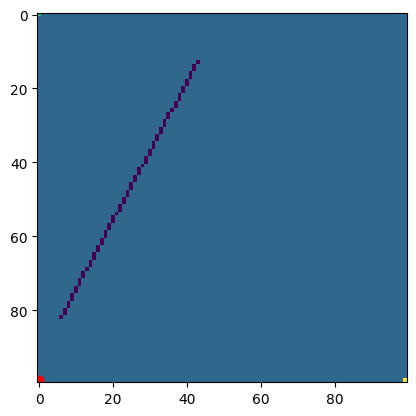

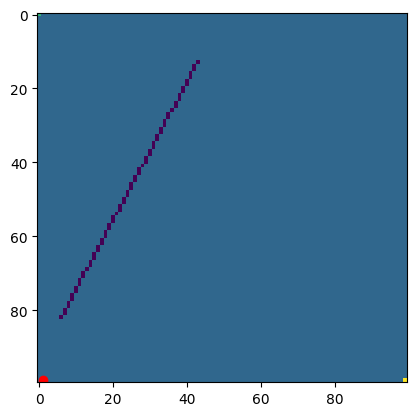

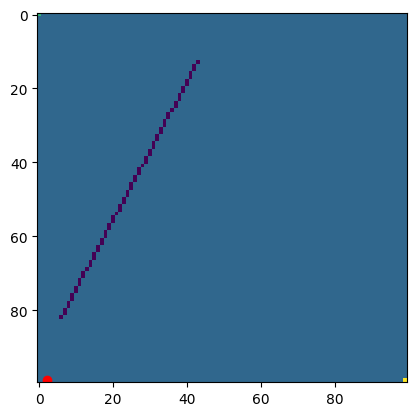

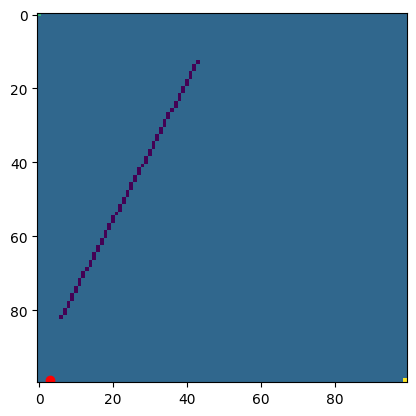

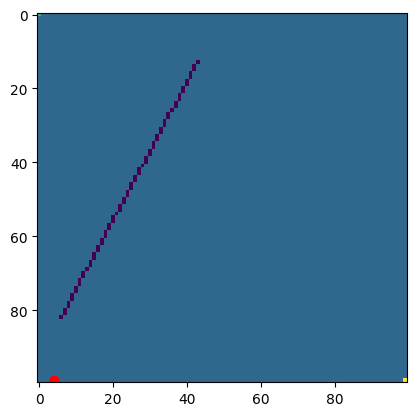

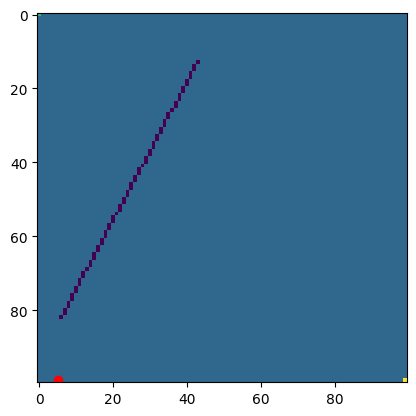

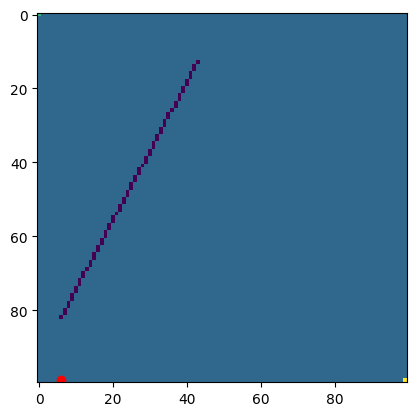

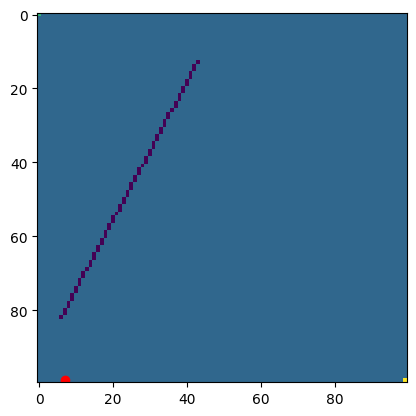

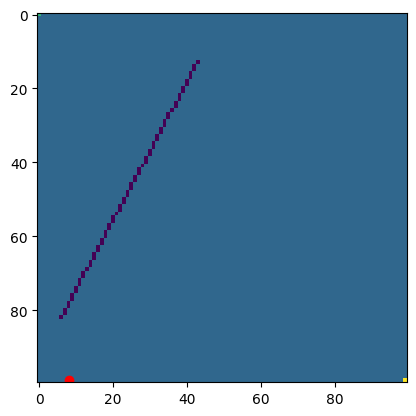

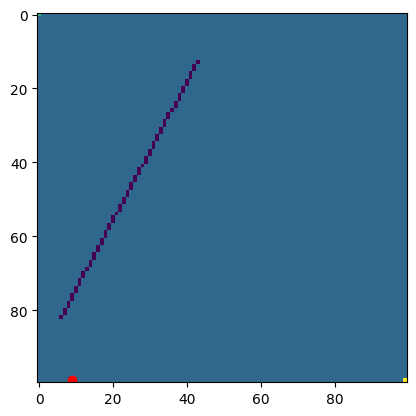

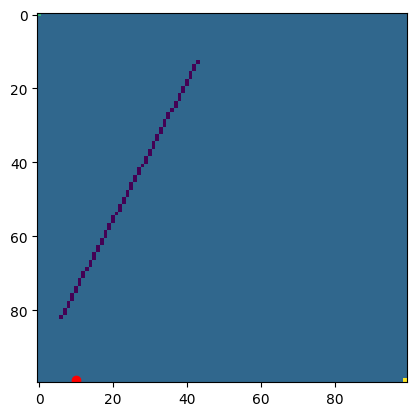

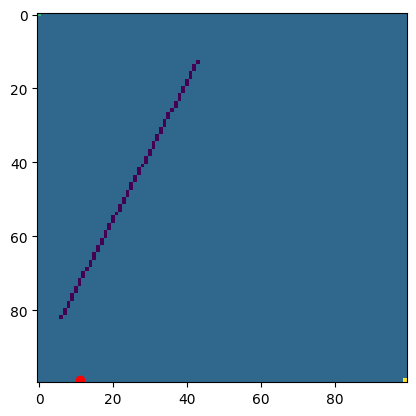

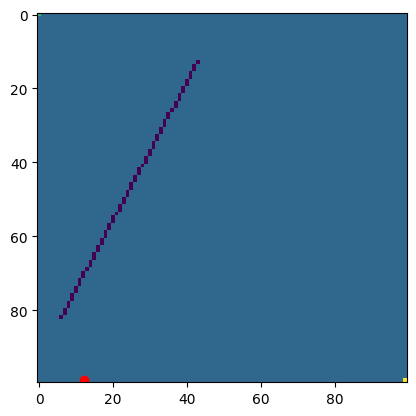

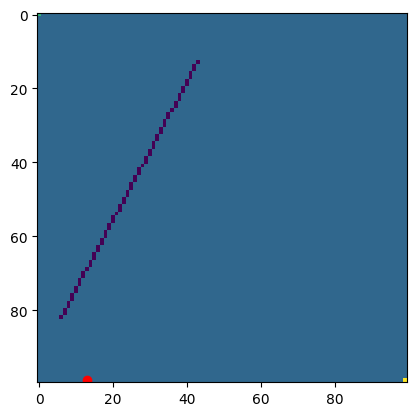

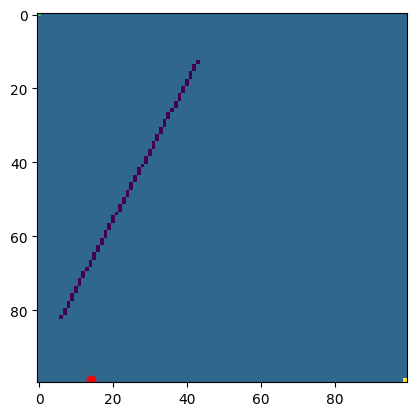

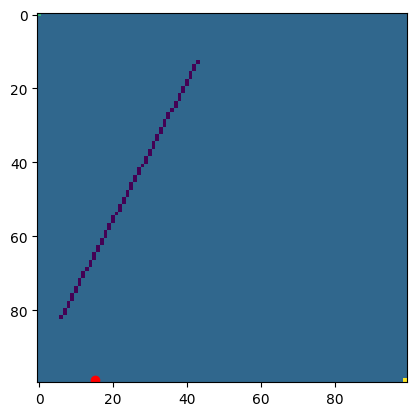

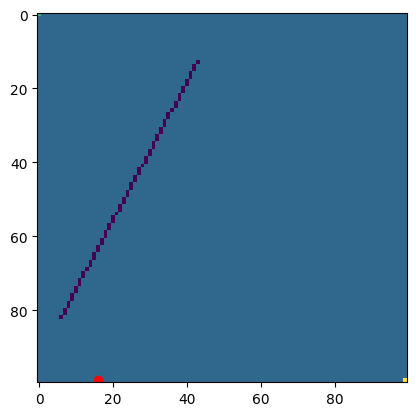

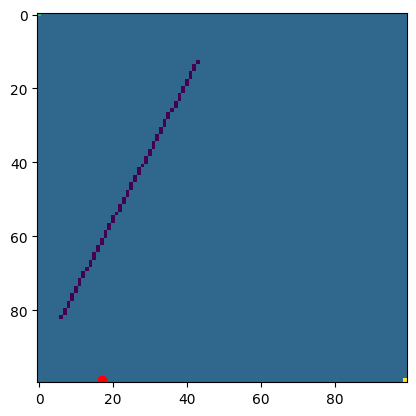

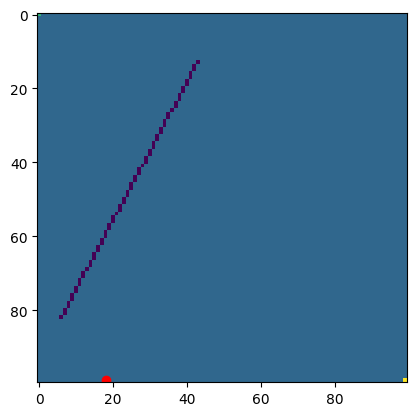

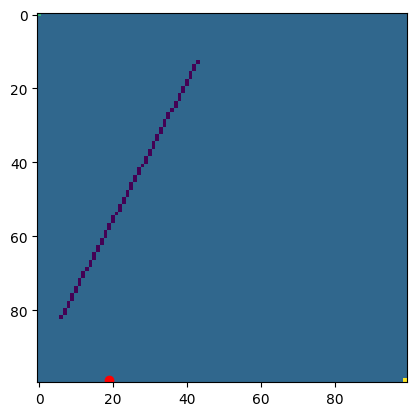

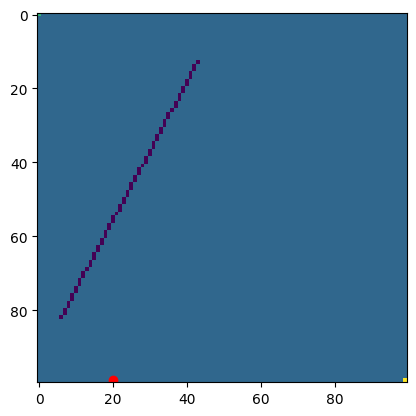

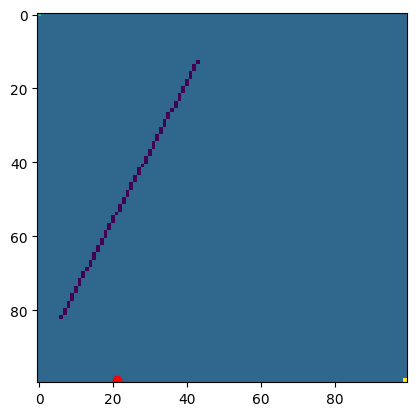

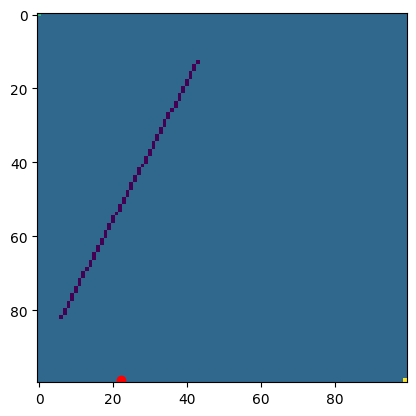

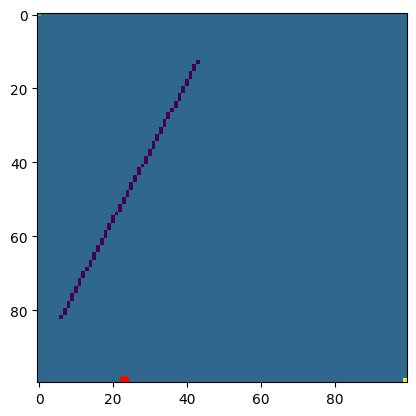

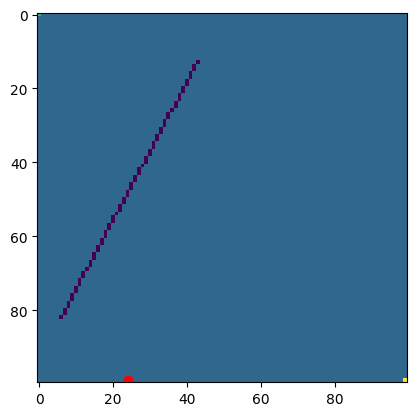

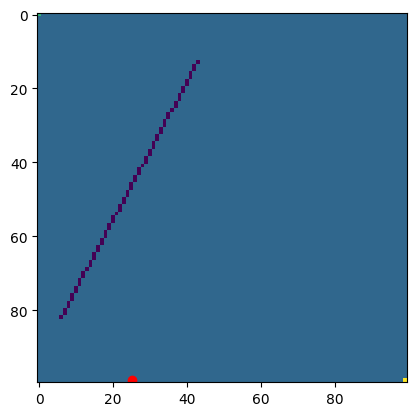

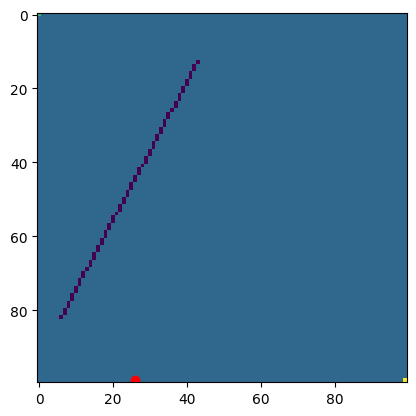

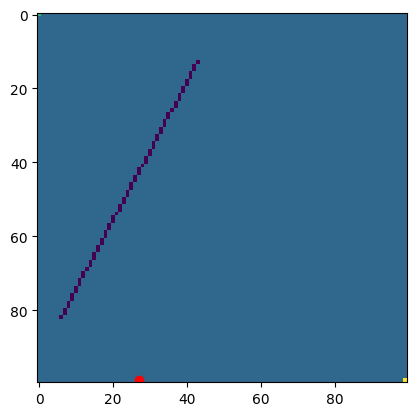

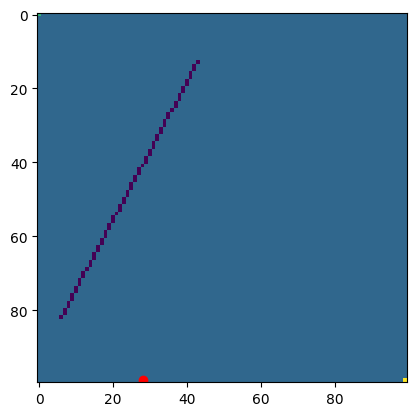

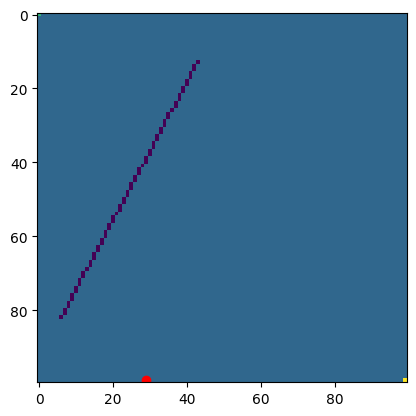

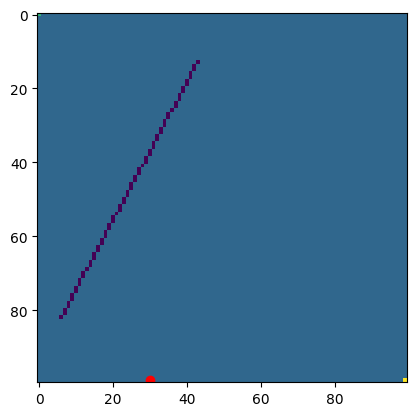

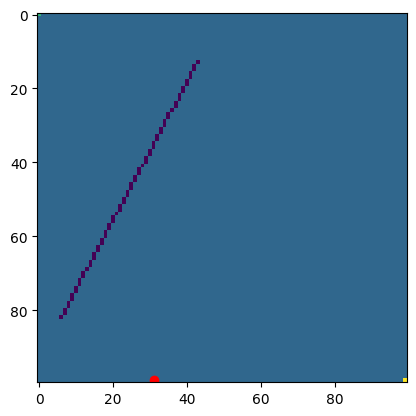

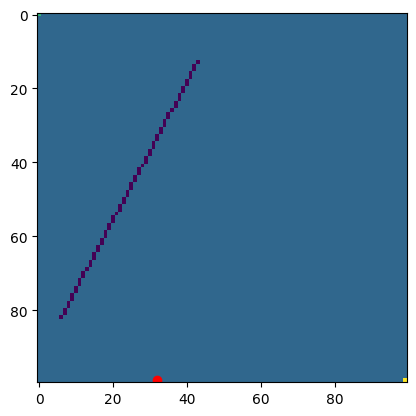

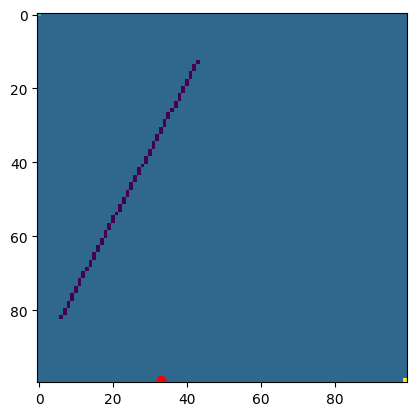

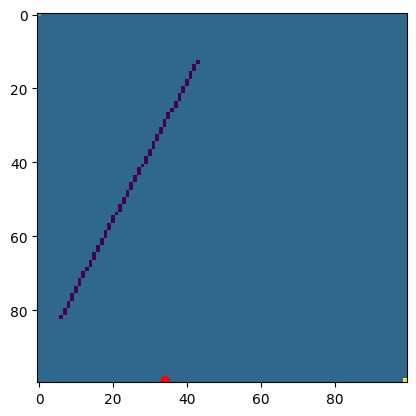

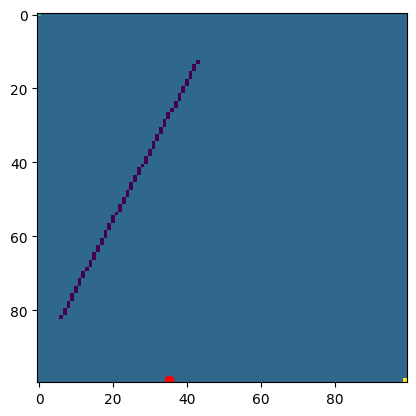

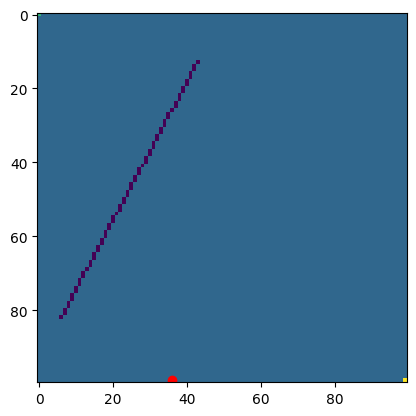

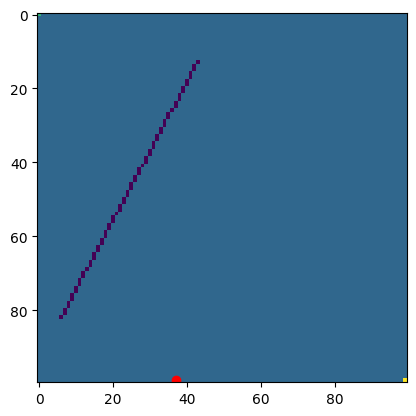

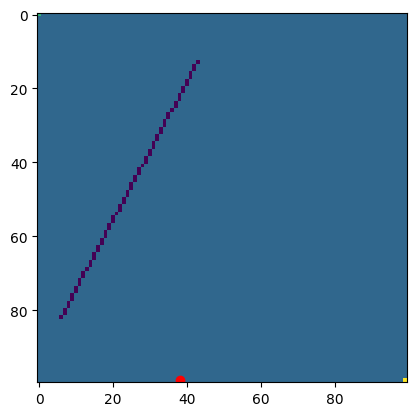

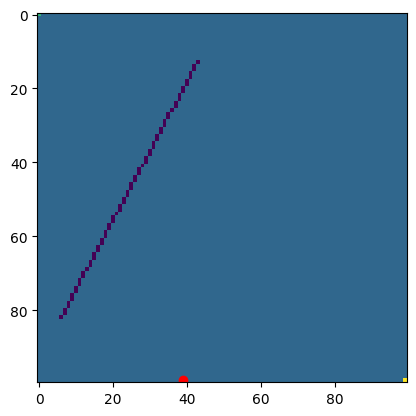

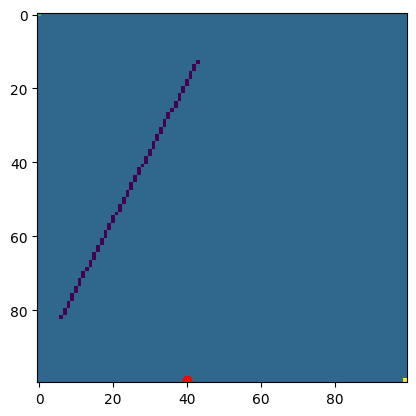

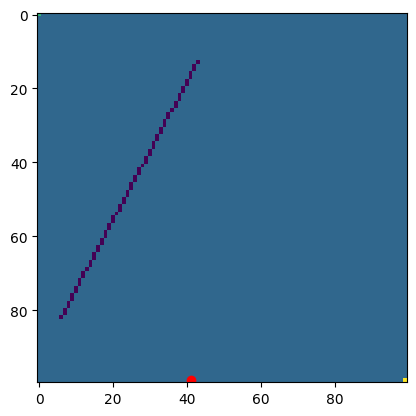

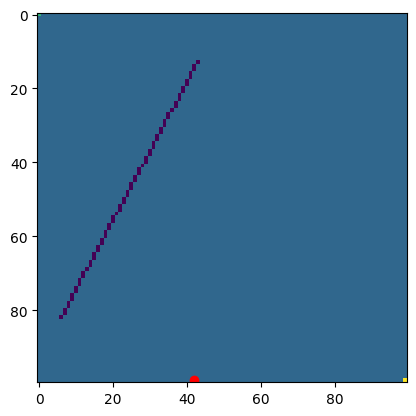

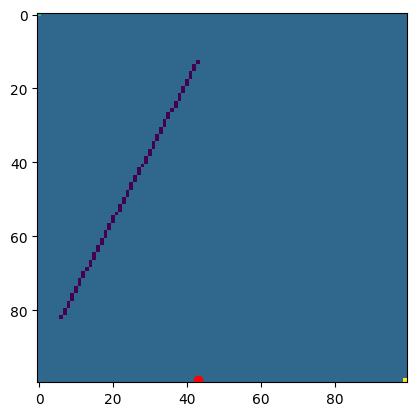

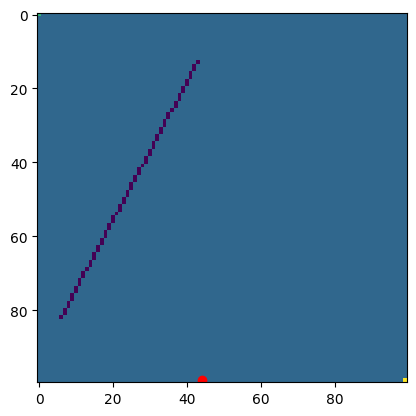

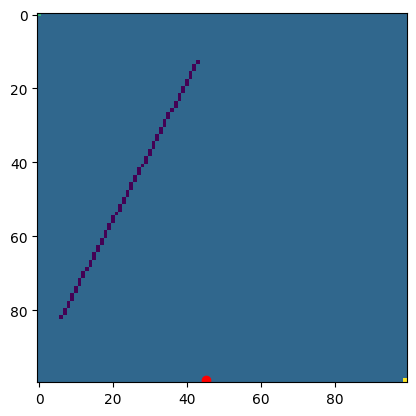

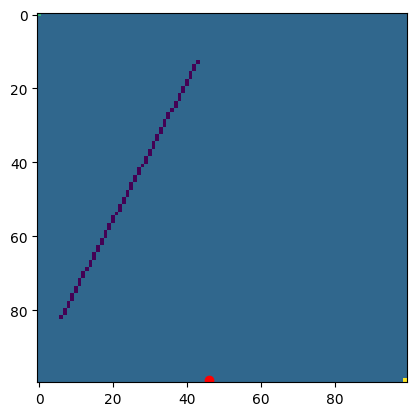

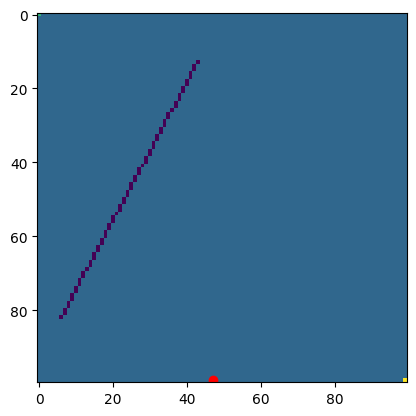

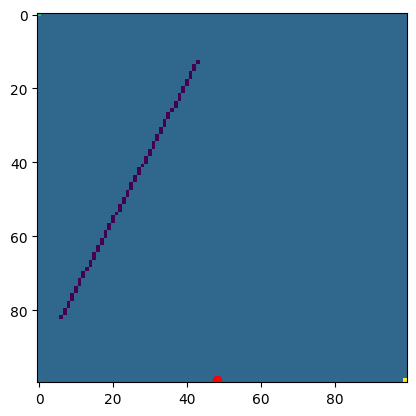

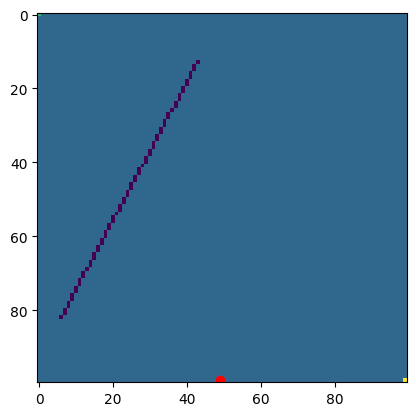

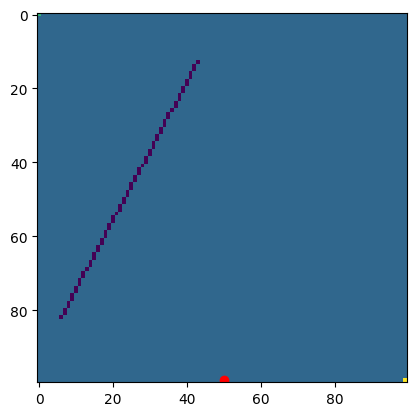

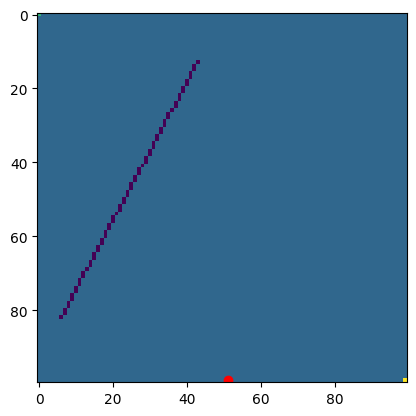

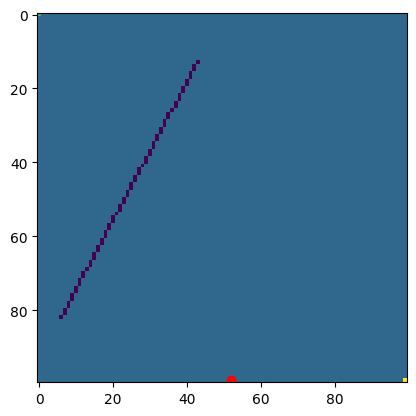

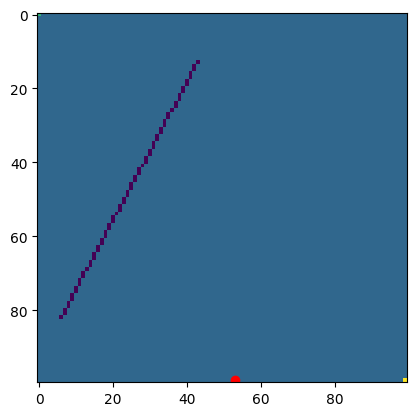

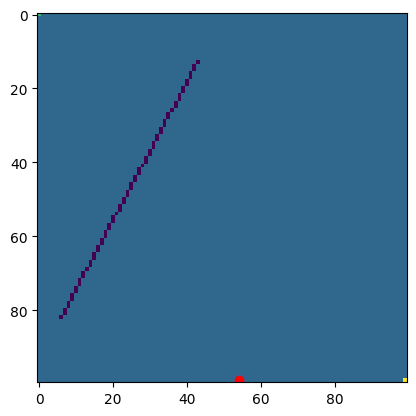

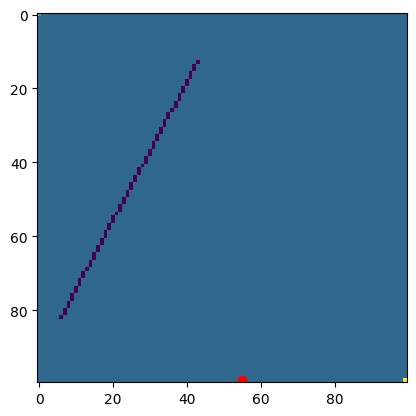

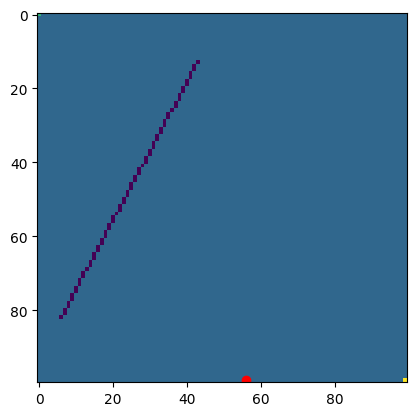

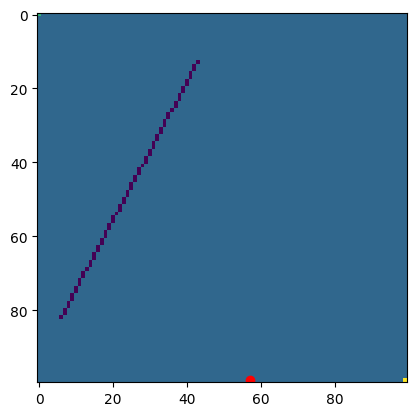

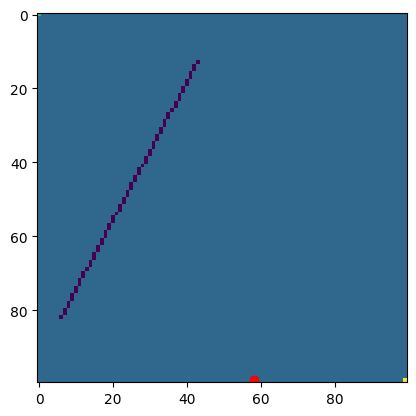

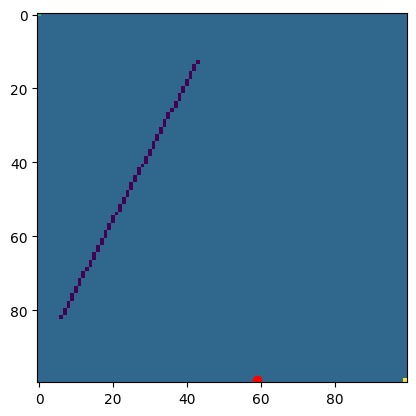

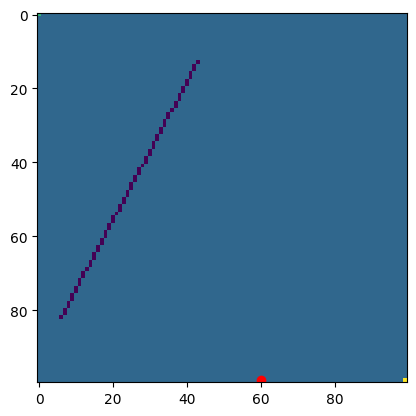

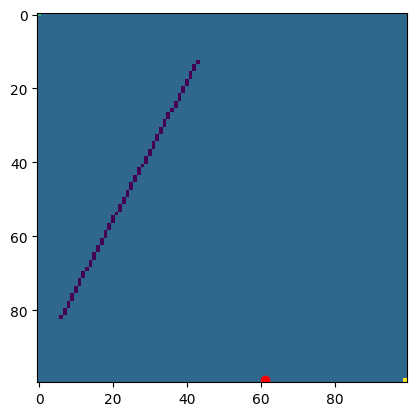

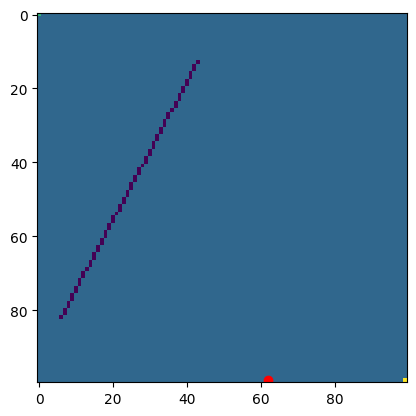

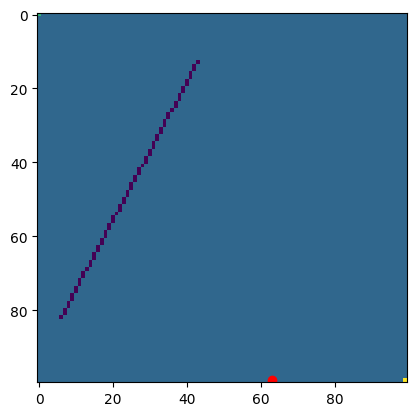

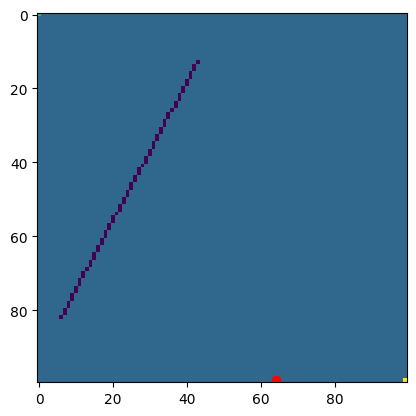

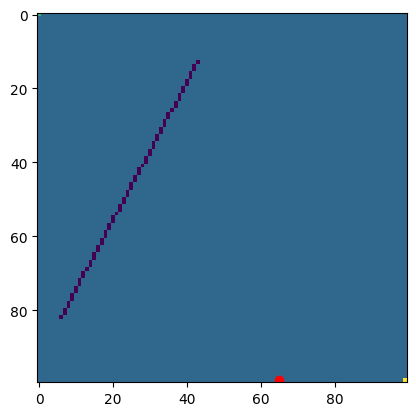

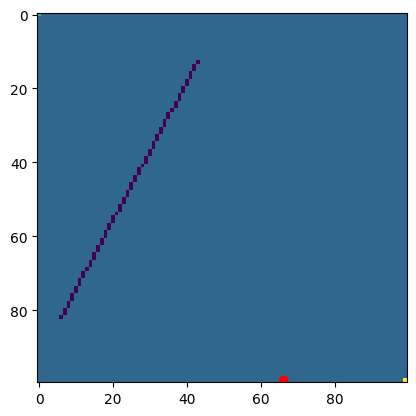

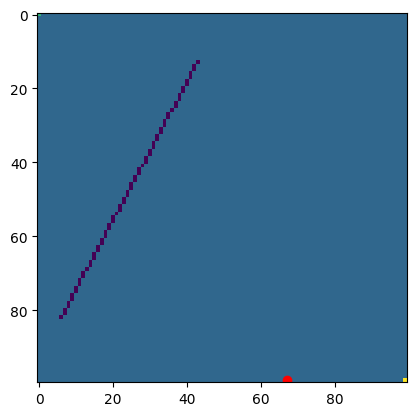

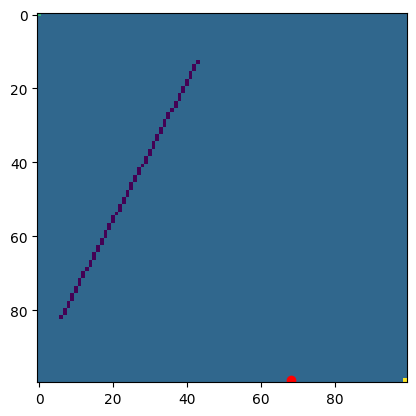

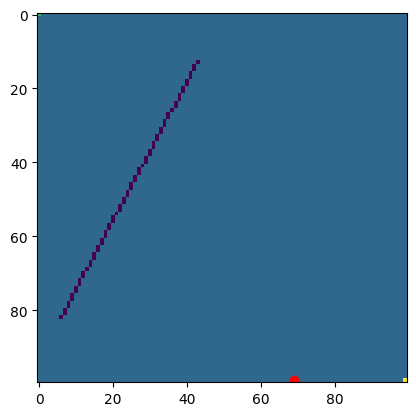

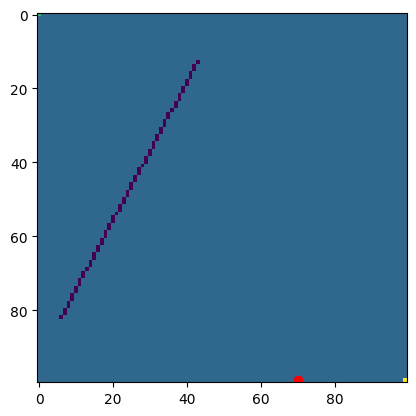

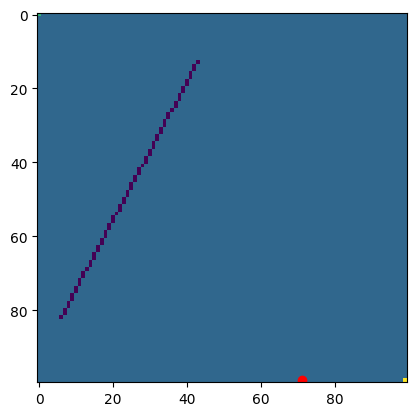

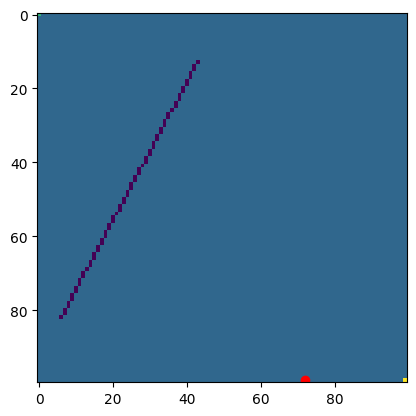

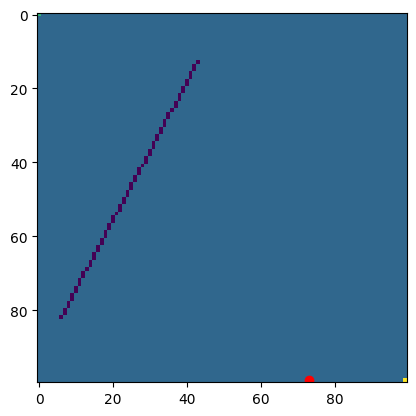

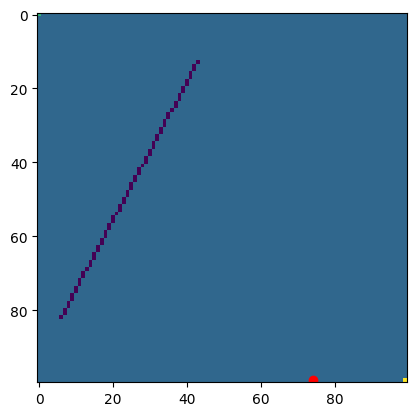

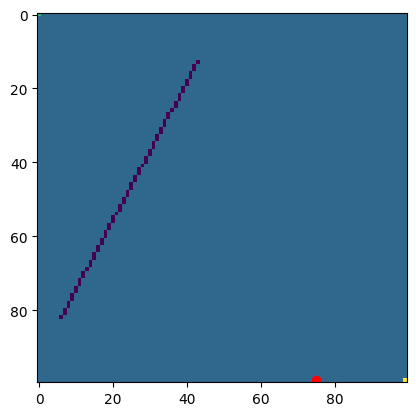

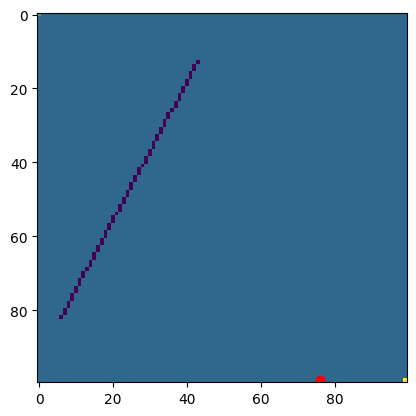

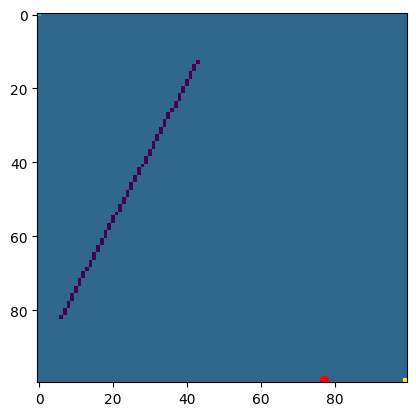

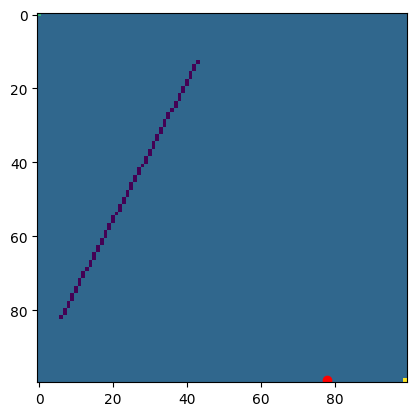

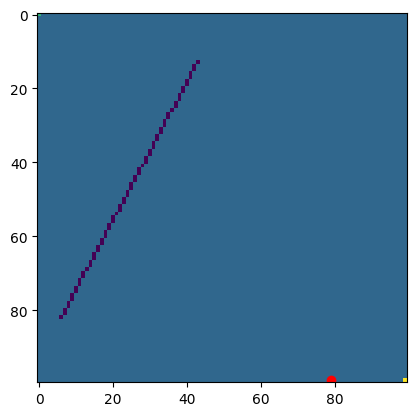

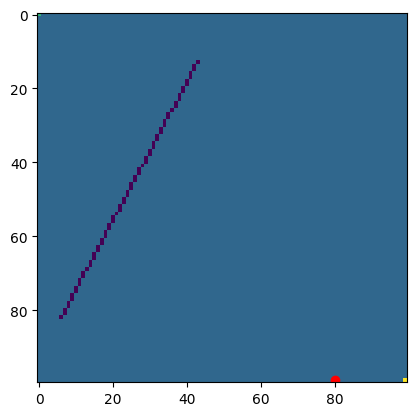

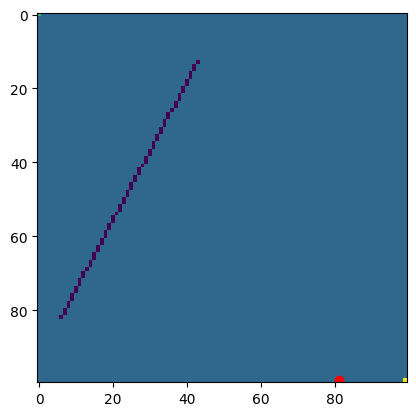

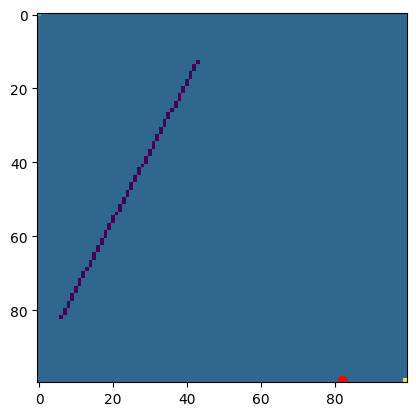

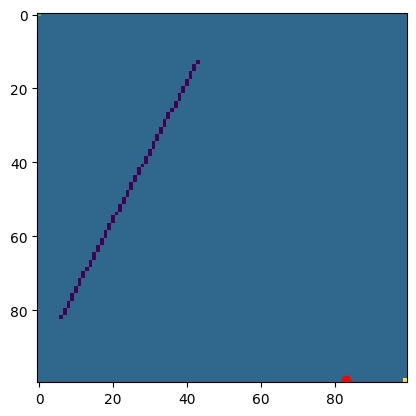

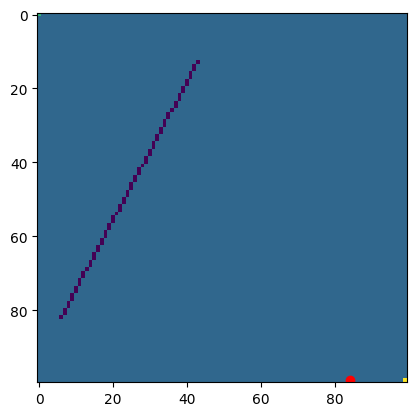

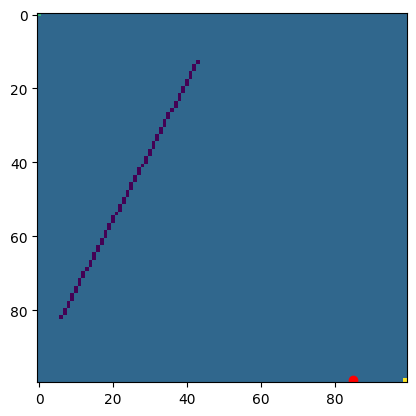

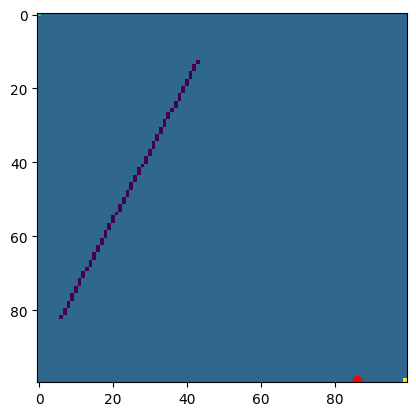

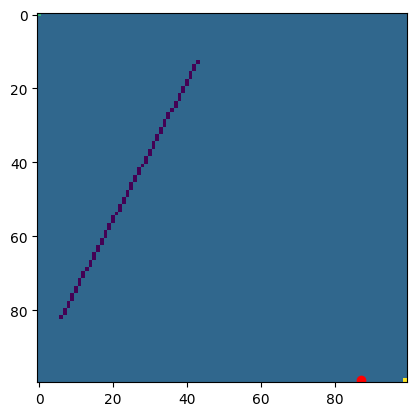

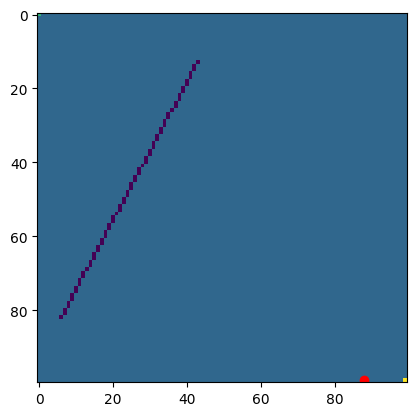

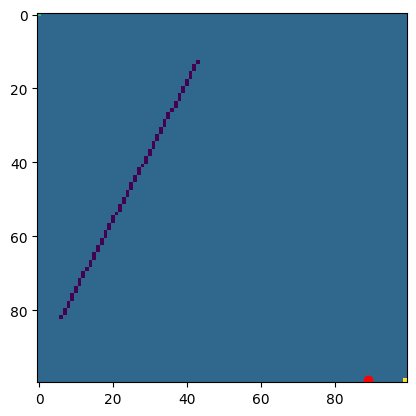

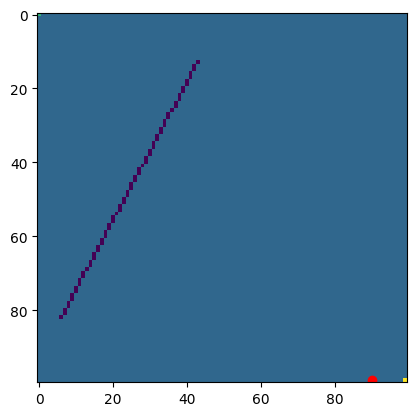

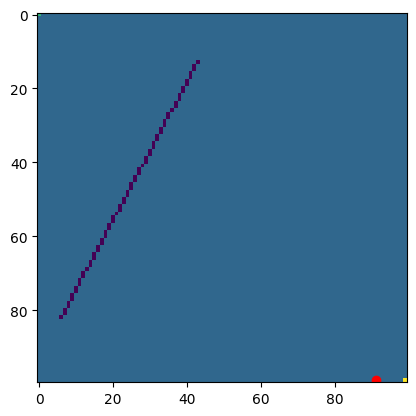

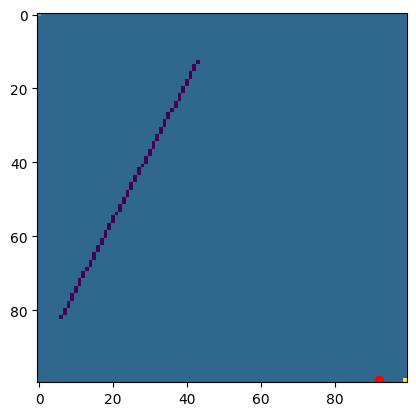

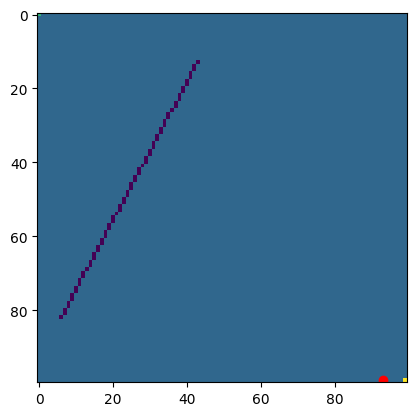

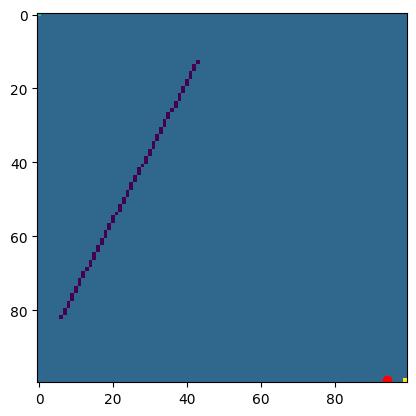

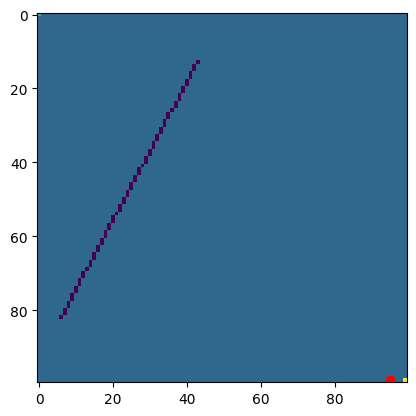

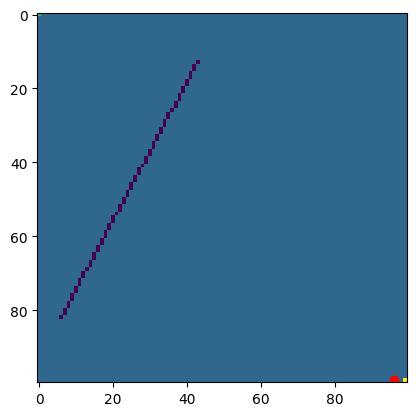

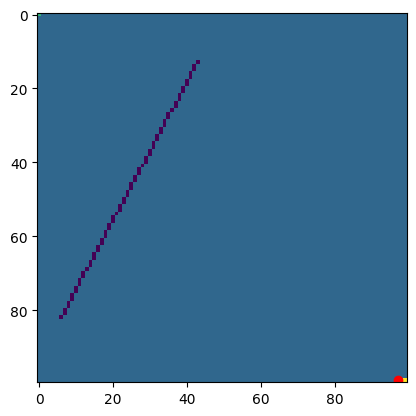

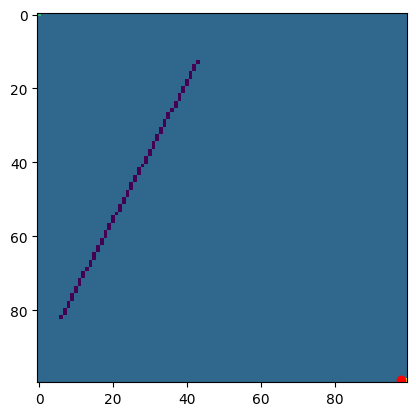

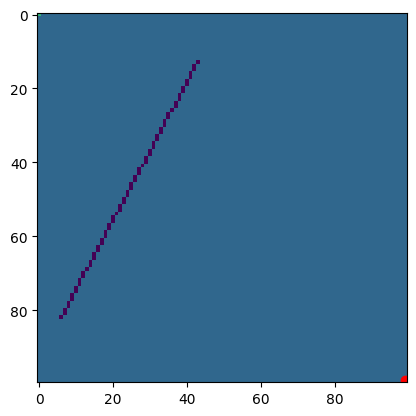

Goal Reached!


In [11]:
import numpy as np
import matplotlib.pyplot as plt
import time

env = GridWorld()

start_time = time.time()
V_vi, policy_vi = value_iteration(env)
end_time = time.time()
print(f"Value Iteration Time: {end_time - start_time:.4f} seconds")

start_time = time.time()
V_pi, policy_pi = policy_iteration(env)
end_time = time.time()
print(f"Policy Iteration Time: {end_time - start_time:.4f} seconds")

start_time = time.time()
Q, rewards_q = q_learning(env)
end_time = time.time()
print(f"Q-learning Time: {end_time - start_time:.4f} seconds")


# Visualization of Policies (Value Iteration)
plt.imshow(policy_vi, cmap='viridis', interpolation='nearest')
plt.title("Value Iteration Policy")
plt.colorbar(ticks=range(4), label="Actions (0:Up, 1:Down, 2:Left, 3:Right)")
plt.show()

# Visualization of Policies (Policy Iteration)
plt.imshow(policy_pi, cmap='viridis', interpolation='nearest')
plt.title("Policy Iteration Policy")
plt.colorbar(ticks=range(4), label="Actions (0:Up, 1:Down, 2:Left, 3:Right)")
plt.show()

# Q-learning Rewards over time
plt.plot(rewards_q)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Q-learning Rewards")
plt.show()


state = env.start
env.render(state)
c=0
while state != env.goal or c<10:
    c+=1
    action = int(policy_vi[state]) # Must convert to int for env.step()
    state, reward, done = env.step(state, action)
    env.render(state)
    if done:
        print("Goal Reached!")
        break